# The impact of currents on microinstabilities in fusion plasmas

In [ ]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import Ellipse, Polygon
import os
import re
from scipy.interpolate import griddata
from scipy.optimize import linear_sum_assignment as lsa
from scipy.special import erf
from sympy import symbols, sqrt, pi


In [4]:
def genfromASCII(filename,labels=None):
    """
    Convert ASCII file into dictionary, where headers become keys (potentially overwritten by `labels`) and numbers below an array.

    Parameters
    ----------
    filename : string
        Path to ASCII file.
    labels : list, optional, default in None
        List of dictionary labels used instead of headers from file. The length must match or surpass the number of data blocks in the ASCII file.
    """
    d = {} # Output dictionary
    number_pattern = r"([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)" # Regular expression pattern to locate number in string, that can have sign, decimals and exponential notation.
    
    # Open ASCII file and read its content
    with open(filename, 'r') as f:
        file = f.read()
    
    i = 0
    # Break-up ASCII text in chuncks at each comment line (#)
    for chunck in file.split('#'):
        # Remove leading and trailing spaces
        chunck = chunck.strip()
        # Search at the start of the string for "text \n number"
        key = re.findall(r"^([^\n]*)\n\s*"+number_pattern,chunck)
        if key:
            # "text" is used as key in the output dictionary
            key = key[0][0].strip()
            chunck = chunck.replace(key,'')                
            
            # To prevent overwriting keys and make them more readable, edit keys with input labels (if provided)
            if labels:
                if i < len(labels):
                    key = labels[i]
                else: 
                    print(f"list of labels is of length {len(labels)} but {i+1} are labels required!",end='\r')
                i += 1
            # Find all numbers following the key
            values = re.findall(number_pattern,chunck)
            # If multiple numbers are found, add array to output dictionary, otherwise add single value
            if len(values) > 1:
                d[key] = np.array([float(v) for v in values])
            elif len(values) == 1:
                d[key] = float(values[0])

    return d


In [5]:
class PARAMETERS:
    """
    Object containing all parameter settings for a GENE simulation, to be accessed in data processing code.
    """
    c = 2.99792458E10   # cm/s
    e = 4.8032047E-10   # Fr
    mp = 1.67262192e-24 # g
    eC = e/c*10 # C

    def __init__(self,**kwargs):
        # Mass (mref)
        self.mi = kwargs.get("mi",1.0)
        self.me = kwargs.get("me",1.0)
        # Temperature (Tref)
        self.T0i = kwargs.get("T0i",1.0)
        self.T0e = kwargs.get("T0e",1.0)
        # Densities (nref)
        self.n0i = kwargs.get("n0i",1.0)
        self.n0e = kwargs.get("n0e",1.0)
        # Charge (e)
        self.qi = kwargs.get("qi",1.0)
        self.qe = kwargs.get("qe",-1.0)
        # Mean parallel background velocity (vTh cref)
        self.vpar0i = kwargs.get("vpar0i",0.0)
        self.vpar0e = kwargs.get("vpar0e",0.0)
        # Mean parallel background velocity gradient (vTh cref/Lref)
        self.gradvpar0i = kwargs.get("gradvpar0i",0.0)
        self.gradvpar0e = kwargs.get("gradvpar0e",0.0)
        # Perpendicular wave numbers (rhoref)
        self.kx = kwargs.get("kx",0.0)
        self.ky = kwargs.get("ky",0.0)
        # Parallel wave number (Lref)
        self.kz = kwargs.get("kz",0.0)
        # Major radius (Lref)
        self.R0 = kwargs.get("R0",1.0)
        # Safety factor (#)
        self.q0 = kwargs.get("q0",1.0)
        # Normalized pressure gradients (#)
        self.omn = kwargs.get("omn",0.0)
        self.omti = kwargs.get("omti",0.0)
        self.omte = kwargs.get("omte",0.0)

        # Get reference values from input, otherwise make sympy symbol
        get_ref = lambda k, m=1.: kwargs[k]*m if kwargs.get(k) is not None else symbols(k)

        self.mref = get_ref("mref",self.mp)
        self.Lref = get_ref("Lref",1e2)
        self.Bref = get_ref("Bref",1e4)
        self.rhostar = get_ref("rhostar")
        self.beta = get_ref("beta")
        self.trpeps = get_ref("trpeps")
        self.x0 = get_ref("x0")
        self.a = kwargs.get("a",self.trpeps*self.R0/self.x0)

        self.Tref = kwargs.get("Tref")*self.eC*1e10 if kwargs.get("Tref") else (self.rhostar/(self.c / self.e * sqrt(self.mref) / (self.a * self.Lref * self.Bref)))**2
        self.nref = kwargs.get("nref")*1e-6 if kwargs.get("nref") else self.beta/(8 * pi * self.n0e * self.Tref / self.Bref**2)

        self.vThi = np.sqrt(2 * self.T0i / self.mi)
        self.vThe = np.sqrt(2 * self.T0e / self.me)
        self.cref = sqrt(self.Tref/self.mref)
        self.Omegaref = self.e * self.Bref / (self.c * self.mref)
        self.rhoref = self.cref / self.Omegaref

        if os.path.exists(kwargs.get("geom","")):
            geom = genfromASCII(kwargs.get("geom"))
            keys = re.split(r"\s{2,}+",list(geom.keys())[0])
            values = list(geom.values())[0]
            values = values.reshape((values.size//len(keys),len(keys))).T
            self.geom = geom = {k:v for (k,v) in zip(keys,values)}
            
            # Parallel coordinate (Lref)
            self.z = geom['z']
            # Geometric factors and curvature (Lref^2)
            self.gamma1 = geom['g_xx']*geom['g_yy']-geom['g_xy']**2
            self.gamma2 = geom['g_xx']*geom['g_yz']-geom['g_xy']*geom['g_xz']
            self.gamma3 = geom['g_xy']*geom['g_yz']-geom['g_yy']*geom['g_xz']
            self.Kx = geom['K_x']
            self.Ky = geom['K_y']
            self.J = geom['jacobian']
            # Magnetic field (Bref)
            self.B0 = geom['B(z)']
            # Radial magnetic field gradient (Bref/Lref)
            self.dB0dx = geom['dBdx']
            self.Omegai = self.qi * self.B0 / self.mi
            self.Omegae = self.qe * self.B0 / self.me

        else: print("No geometric data provided, some functions will be unavailable!")

    def omega_drift(self,vpar,mu,zi=None):
        if zi is None: zi = int(len(self.B0)/2)
        K = (self.Kx*self.kx + self.Ky*self.ky + (self.gamma2/self.gamma1*self.Ky-self.gamma3/self.gamma1*self.Kx)*self.kz/self.Lref*self.rhoref)[zi]
        omdi = self.vThi**2/self.Omegai[zi]*K/2*(2*vpar**2+self.B0[zi]*mu)
        omde = self.vThe**2/self.Omegae[zi]*K/2*(2*vpar**2+self.B0[zi]*mu)
        return omdi,omde
    
    def omega_star(self,vpar,mu,zi=None):
        if zi is None: zi = int(len(self.B0)/2)
        ktilde = (self.B0*(self.ky+self.gamma2/self.gamma1*self.kz/self.Lref*self.rhoref))[zi]
        omsi = -self.omn - self.omti*((vpar-self.vpar0i)**2+mu*self.B0[zi]-3/2) +2*(vpar-self.vpar0i)*self.gradvpar0i-self.vpar0i/vpar*mu*self.dB0dx[zi]
        omse = -self.omn - self.omte*((vpar-self.vpar0e)**2+mu*self.B0[zi]-3/2) +2*(vpar-self.vpar0e)*self.gradvpar0e-self.vpar0e/vpar*mu*self.dB0dx[zi]
        oms = ktilde/2*np.array([omsi*self.vThi**2/self.Omegai[zi],
                                 omse*self.vThe**2/self.Omegae[zi]])
        return oms


In [6]:
parameters_RFP_nTEM = PARAMETERS(
    mi=1, me=2.733115e-4, mref=2, T0i=0.4, T0e=1.0, Tref=None,
    R0=1.0, x0=0.83, trpeps=0.27666667, ky=0.1275, kz=2.43, Lref=1.5,
    beta=8.7727363e-4, rhostar=1.0172069e-2, Bref=0.48467032035730001,
    coll=1.1052151E-03, q0=6.3258439e-2, omn=30.366076, 
    omti=17.916631,omte=17.916631,
    geom=fr"/home/leon-o/Documents/Code/Microinstabilities/geometry_RFP.dat"
)
parameters_Tokamak_nTEM = PARAMETERS(
    mi=1.0, me=0.0005447, mref=1.0, T0i=1.0, T0e=1.0, Tref=None,
    R0=1.0, x0=None, trpeps=0.18, ky=0.3, kz=1.5, Lref=1.0,
    beta=3.0e-3, rhostar=None, Bref=None,
    coll=0.0, q0=1.4, omn=2.22, omti=6.96, omte=6.96,
    geom=fr"/home/leon-o/Documents/Code/Microinstabilities/geometry_Tokamak.dat"
)
parameters_Tokamak_ITG = PARAMETERS(
    mi=1.0, me=0.0005447, mref=1.0, T0i=1.0, T0e=1.0, Tref=None,
    R0=1.0, x0=None, trpeps=0.18, ky=0.3, kz=1.5, Lref=1.0,
    beta=3.0e-3, rhostar=None, Bref=None,
    coll=0.0, q0=1.4, omn=2.22, omti=6.96, omte=0.0,
    geom=fr"/home/leon-o/Documents/Code/Microinstabilities/geometry_Tokamak.dat"
)

## Effect of mean parallel equilibrium velocity

In [10]:
## Data
eigenvalues = {
    # RFP nTEM
    'RFP_nTEM_ky01275': np.array([
        [[-0.1,-0.1],[-0.1,0.1],[0.1,-0.1],[0.1,0.1],[0,0],[-0.1,0],[0.1,0],[0,-0.1],[0,0.1]], # vpar0[i,e]
        [[0.118,-0.095],[0.187,-0.138],[0.187,-0.138],[0.118,-0.095],[0.159,-0.116],[0.159,-0.117],[0.159,-0.117],[0.148,-0.113],[0.148,-0.113]]]), # [gamma,omega]
    # RFP nTIM
    'RFP_TIM_ky03000': np.array([
        [[-0.1,-0.1],[-0.1,0.1],[0.1,-0.1],[0.1,0.1],[0,0]], # vpar0[i,e]
        [[0.035,0.459],[0.071,0.419],[0.071,0.419],[0.035,0.459],[0.061,0.443]]]),  # (gamma,omega)
    # Tokamak nTEM
    'Tokamak_nTEM_ky03000': np.array([
        [[-0.1,-0.1],[-0.1,0.1],[0.1,-0.1],[0.1,0.1],[0,0],[-0.1,0],[0.1,0],[0,-0.1],[0,0.1]], # vpar0[i,e]
        [[0.943,-0.227],[0.942,-0.229],[0.942,-0.229],[0.943,-0.227],[0.910,-0.213],[0.912,-0.229],[0.912,-0.229],[0.941,-0.220],[0.941,-0.220]]]),  # (gamma,omega)
    # Tokamak ITG
    'Tokamak_ITG_ky03000': np.array([
        [[-0.1,-0.1],[-0.1,0.1],[0.1,-0.1],[0.1,0.1],[0,0],[-0.1,0],[0.1,0],[0,-0.1],[0,0.1]], # vpar0[i,e]
        [[0.429,1.157],[0.340,1.145],[0.340,1.145],[0.429,1.157],[0.395,1.155],[0.388,1.147],[0.388,1.147],[0.393,1.158],[0.393,1.158]]]), # (gamma,omega)
}

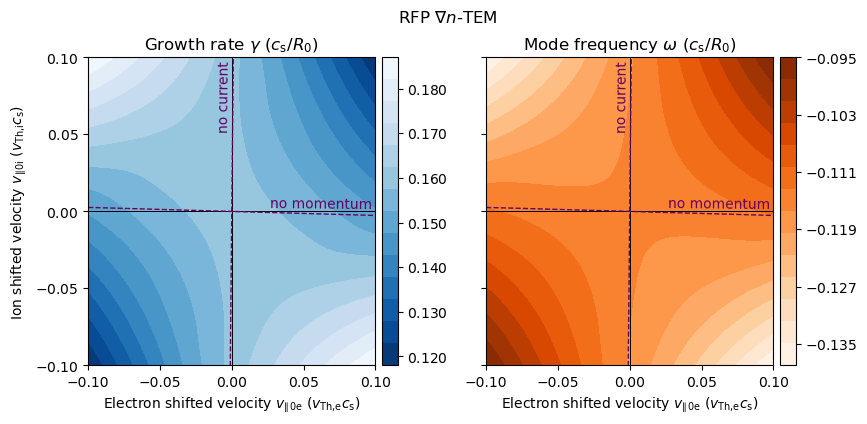

In [12]:
# Get velocities and eigenvalues from data dictionary
V, O = eigenvalues['RFP_nTEM_ky01275']
# Get parameters for this simulation
par = parameters_RFP_nTEM
# Set levels and ticks for gamma and omega
lg = np.linspace(0.118,0.187,15)
tg = np.arange(0.120,0.181,0.010)
lo = np.linspace(-0.138,-0.095,15)
to = np.arange(-0.135,-0.095,0.008)

# Interpolate data for clean plot
N = 500
Vi, Ve = np.mgrid[V[:,0].min():V[:,0].max():N*1j,V[:,1].min():V[:,1].max():N*1j]
gamma = griddata(V, O[:,0], (Vi, Ve), method='cubic')
omega = griddata(V, O[:,1], (Vi, Ve), method='cubic')

# Create figure
fig, ax = plt.subplots(1,2,figsize=(9.6,4),sharey=True,gridspec_kw={'wspace':0.15})

cf = ax[0].contourf(Ve,Vi,gamma,cmap='Blues_r',levels=lg)
ax[0].set_title(r'Growth rate $\gamma$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
cbar.ax.set_yticks(tg, [f"${t:.3f}$" for t in tg]) 

cf = ax[1].contourf(Ve,Vi,omega,levels=lo,cmap='Oranges')
ax[1].set_title(r'Mode frequency $\omega$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
cbar.ax.set_yticks(to, [f"${t:.3f}$" for t in to]) 

for axi in ax:
    axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
    axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
    axi.set_xlabel(r"Electron shifted velocity $v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{s}$)")
    axi.set_xlim(Ve.min(),Ve.max())

    c_an = '#660260'
    axi.plot([-0.1,0.1],[-0.1*par.vThe/par.vThi,0.1*par.vThe/par.vThi],c=c_an,lw=1,ls='--')
    axi.annotate("no current",[0,0.098],c=c_an,rotation=89.4,va='top',ha='right')
    axi.plot([-0.1,0.1],[0.1*par.vThe/par.vThi*par.me/par.mi,-0.1*par.vThe/par.vThi*par.me/par.mi],c=c_an,lw=1,ls='--')
    axi.annotate("no momentum",[0.098,0],c=c_an,rotation=-0.6,va='bottom',ha='right')

ax[0].set_ylim(Vi.min(),Vi.max())
ticks = np.linspace(-0.1,0.1,5)
ax[0].set_yticks(ticks,[f"${t:.2f}$" for t in ticks])
ax[0].set_ylabel(r"Ion shifted velocity $v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}c_\text{s}$)")
fig.suptitle(r"RFP $\nabla n$-TEM",y=1)

plt.savefig("eigenvalues_RFP_nTEM.pdf",bbox_inches='tight')

plt.show()

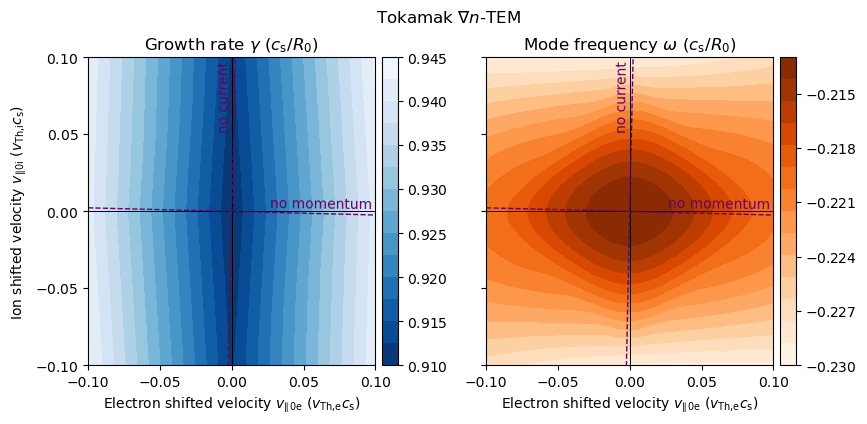

In [ ]:
# Get velocities and eigenvalues from data dictionary
V, O = eigenvalues['Tokamak_nTEM_ky03000']
# Get parameters for this simulation
par = parameters_Tokamak_nTEM
# Set levels and ticks for gamma and omega
lg = np.linspace(0.910,0.945,15)
tg = np.arange(0.910,0.946,0.005)
lo = np.linspace(-0.230,-0.213,15)
to = np.arange(-0.230,-0.213,0.003)

# Interpolate data for clean plot
N = 500
Vi, Ve = np.mgrid[V[:,0].min():V[:,0].max():N*1j,V[:,1].min():V[:,1].max():N*1j]
gamma = griddata(V, O[:,0], (Vi, Ve), method='linear')
omega = griddata(V, O[:,1], (Vi, Ve), method='cubic')

# Create figure
fig, ax = plt.subplots(1,2,figsize=(9.6,4),sharey=True,gridspec_kw={'wspace':0.15})

cf = ax[0].contourf(Ve,Vi,gamma,cmap='Blues_r',levels=lg)
ax[0].set_title(r'Growth rate $\gamma$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
cbar.ax.set_yticks(tg, [f"${t:.3f}$" for t in tg]) 

cf = ax[1].contourf(Ve,Vi,omega,levels=lo,cmap='Oranges')
ax[1].set_title(r'Mode frequency $\omega$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
cbar.ax.set_yticks(to, [f"${t:.3f}$" for t in to]) 

for axi in ax:
    axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
    axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
    axi.set_xlabel(r"Electron shifted velocity $v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{s}$)")
    axi.set_xlim(Ve.min(),Ve.max())

    c_an = '#660260'
    axi.plot([-0.1,0.1],[-0.1*par.vThe/par.vThi,0.1*par.vThe/par.vThi],c=c_an,lw=1,ls='--')
    axi.annotate("no current",[0,0.098],c=c_an,rotation=89.4,va='top',ha='right')
    axi.plot([-0.1,0.1],[0.1*par.vThe/par.vThi*par.me/par.mi,-0.1*par.vThe/par.vThi*par.me/par.mi],c=c_an,lw=1,ls='--')
    axi.annotate("no momentum",[0.098,0],c=c_an,rotation=-0.6,va='bottom',ha='right')

ax[0].set_ylim(Vi.min(),Vi.max())
ticks = np.linspace(-0.1,0.1,5)
ax[0].set_yticks(ticks,[f"${t:.2f}$" for t in ticks])
ax[0].set_ylabel(r"Ion shifted velocity $v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}c_\text{s}$)")
fig.suptitle(r"Tokamak $\nabla n$-TEM",y=1)

plt.savefig("eigenvalues_tokamak_nTEM.pdf",bbox_inches='tight')

plt.show()

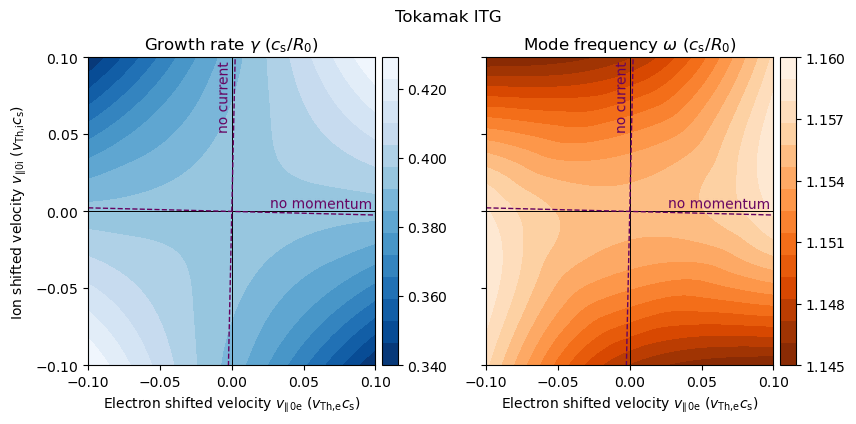

In [ ]:
# Get velocities and eigenvalues from data dictionary
V, O = eigenvalues['Tokamak_ITG_ky03000']
# Get parameters for this simulation
par = parameters_Tokamak_ITG
# Set levels and ticks for gamma and omega
lg = np.linspace(0.340,0.429,15)
tg = np.arange(0.340,0.429,0.020)
lo = np.linspace(1.145,1.160,15)
to = np.arange(1.145,1.161,0.003)

# Interpolate data for clean plot
N = 500
Vi, Ve = np.mgrid[V[:,0].min():V[:,0].max():N*1j,V[:,1].min():V[:,1].max():N*1j]
gamma = griddata(V, O[:,0], (Vi, Ve), method='cubic')
omega = griddata(V, O[:,1], (Vi, Ve), method='cubic')

# Create figure
fig, ax = plt.subplots(1,2,figsize=(9.6,4),sharey=True,gridspec_kw={'wspace':0.15})

cf = ax[0].contourf(Ve,Vi,gamma,cmap='Blues_r',levels=lg)
ax[0].set_title(r'Growth rate $\gamma$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
cbar.ax.set_yticks(tg, [f"${t:.3f}$" for t in tg]) 

cf = ax[1].contourf(Ve,Vi,omega,levels=lo,cmap='Oranges_r')
ax[1].set_title(r'Mode frequency $\omega$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
cbar.ax.set_yticks(to, [f"${t:.3f}$" for t in to]) 

for axi in ax:
    axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
    axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
    axi.set_xlabel(r"Electron shifted velocity $v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{s}$)")
    axi.set_xlim(Ve.min(),Ve.max())

    c_an = '#660260'
    axi.plot([-0.1,0.1],[-0.1*par.vThe/par.vThi,0.1*par.vThe/par.vThi],c=c_an,lw=1,ls='--')
    axi.annotate("no current",[0,0.098],c=c_an,rotation=89.4,va='top',ha='right')
    axi.plot([-0.1,0.1],[0.1*par.vThe/par.vThi*par.me/par.mi,-0.1*par.vThe/par.vThi*par.me/par.mi],c=c_an,lw=1,ls='--')
    axi.annotate("no momentum",[0.098,0],c=c_an,rotation=-0.6,va='bottom',ha='right')

ax[0].set_ylim(Vi.min(),Vi.max())
ticks = np.linspace(-0.1,0.1,5)
ax[0].set_yticks(ticks,[f"${t:.2f}$" for t in ticks])
ax[0].set_ylabel(r"Ion shifted velocity $v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}c_\text{s}$)")
fig.suptitle(r"Tokamak ITG",y=1)

plt.savefig("eigenvalues_tokamak_ITG.pdf",bbox_inches='tight')

plt.show()

## Effect of mean parallel equilibrium velocity gradient

In [ ]:
## Data
eigenvalues = {
    # RFP nTEM
    'RFP_nTEM_ky01275_par': np.array([
        [[0.000,-0.425],[0.000,-0.170],[0.000,0.000],[0.000,0.170],[0.000,0.425]],
        [[0.118,-0.095],[0.118,-0.094],[0.118,-0.095],[0.118,-0.095],[0.118,-0.096]]]),
    'RFP_nTEM_ky01275_opp': np.array([
        [[0.000,-0.425],[0.000,-0.170],[0.000,0.000],[0.000,0.170],[0.000,0.425]],
        [[0.187,-0.139],[0.187,-0.139],[0.187,-0.138],[0.187,-0.138],[0.187,-0.137]]]),
    'Tokamak_ITG_ky03000_par': np.array([
        [[-0.425,-0.425],[-0.425,0.],[-0.425,0.425],
         [0.,-0.425],[0.,0.],[0.,0.425],
         [0.425,-0.425],[0.425,0.],[0.425,0.425]],
        [[0.440,1.166],[0.443,1.162],[0.450,1.165],
         [0.427,1.161],[0.411,1.151],[0.435,1.160],
         [0.416,1.156],[0.416,1.152],[0.421,1.156]]]),
    'Tokamak_ITG_ky03000_opp': np.array([
        [[-0.425,-0.425],[-0.425,0.],[-0.425,0.425],
         [0.,-0.425],[0.,0.],[0.,0.425],
         [0.425,-0.425],[0.425,0.],[0.425,0.425]],
        [[0.322,1.126],[0.316,1.118],[0.316,1.117],
         [0.348,1.153],[0.313,1.140],[0.340,1.145],
         [0.375,1.179],[0.367,1.172],[0.365,1.172]]]),
    'Tokamak_nTEM_ky03000_par': np.array([
        [[-0.425,-0.425],[-0.425,0.],[-0.425,0.425],
         [0.,-0.425],[0.,0.],[0.,0.425],
         [0.425,-0.425],[0.425,0.],[0.425,0.425]],
        [[0.924,-0.208],[0.940,-0.218],[0.969,-0.225],
         [0.927,-0.218],[0.943,-0.227],[0.972,-0.234],
         [0.930,-0.228],[0.945,-0.236],[0.974,-0.241]]]),
    'Tokamak_nTEM_ky03000_opp': np.array([
        [[-0.425,-0.425],[-0.425,0.],[-0.425,0.425],
         [0.,-0.425],[0.,0.],[0.,0.425],
         [0.425,-0.425],[0.425,0.],[0.425,0.425]],
        [[0.974,-0.242],[0.945,-0.235],[0.928,-0.226],
         [0.973,-0.220],[0.942,-0.229],[0.925,-0.203],
         [0.971,-0.198],[0.941,-0.189],[0.923,-0.179]]])
}

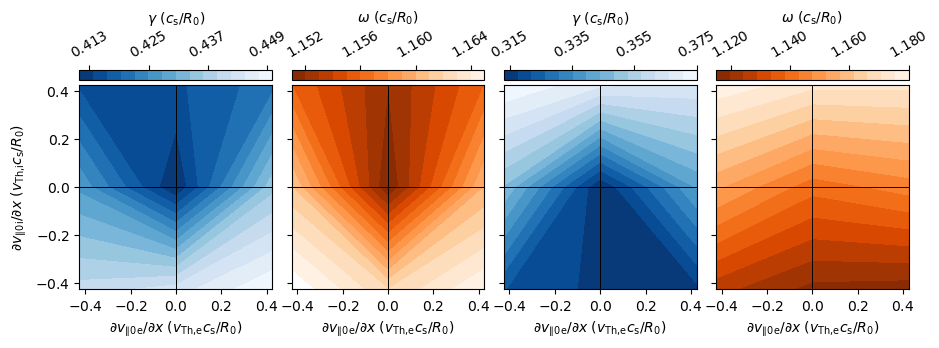

In [ ]:
# Get velocities and eigenvalues from data dictionary
V, O1 = eigenvalues['Tokamak_ITG_ky03000_par']
_, O2 = eigenvalues['Tokamak_ITG_ky03000_opp']
# Set levels and ticks for gamma and omega
lg1 = np.linspace(0.411,0.450,15)
tg1 = np.arange(0.413,0.450,0.012)
lo1 = np.linspace(1.151,1.165,15)
to1 = np.arange(1.152,1.165,0.004)
lg2 = np.linspace(0.313,0.375,15)
tg2 = np.arange(0.315,0.376,0.020)
lo2 = np.linspace(1.115,1.180,15)
to2 = np.arange(1.120,1.181,0.020)

# Interpolate data for clean plot
N = 3
Vi, Ve = np.mgrid[V[:,0].min():V[:,0].max():N*1j,V[:,1].min():V[:,1].max():N*1j]
gamma1 = griddata(V, O1[:,0], (Vi, Ve), method='cubic')
gamma2 = griddata(V, O2[:,0], (Vi, Ve), method='cubic')
omega1 = griddata(V, O1[:,1], (Vi, Ve), method='cubic')
omega2 = griddata(V, O2[:,1], (Vi, Ve), method='cubic')

# Create figure
fig, ax = plt.subplots(1,4,figsize=(10.7,3.2),sharey=True,gridspec_kw={'wspace':0.1})

cf = ax[0].contourf(Ve,Vi,gamma1,cmap='Blues_r',levels=lg1)
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\gamma$ ($c_\text{s}/R_0$)')
cbar.ax.set_xticks(tg1, [f"${t:.3f}$" for t in tg1], rotation=30) 

cf = ax[1].contourf(Ve,Vi,omega1,levels=lo1,cmap='Oranges_r')
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\omega$ ($c_\text{s}/R_0$)')
cbar.ax.set_xticks(to1, [f"${t:.3f}$" for t in to1], rotation=30) 

cf = ax[2].contourf(Ve,Vi,gamma2,cmap='Blues_r',levels=lg2)
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\gamma$ ($c_\text{s}/R_0$)')
cbar.ax.set_xticks(tg2, [f"${t:.3f}$" for t in tg2], rotation=30)  

cf = ax[3].contourf(Ve,Vi,omega2,levels=lo2,cmap='Oranges_r')
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\omega$ ($c_\text{s}/R_0$)')
cbar.ax.set_xticks(to2, [f"${t:.3f}$" for t in to2], rotation=30) 

ticks = np.linspace(-0.4,0.4,5)
for axi in ax:
    axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
    axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
    axi.set_xlabel(r"$\partial v_{\!\parallel\!0\text{e}}/\partial x$ ($v_\text{Th,e}c_\text{s}/R_0$)")
    axi.set_xlim(Ve.min(),Ve.max())
    axi.set_xticks(ticks,[f"${t:.1f}$" for t in ticks])

ax[0].set_ylim(Vi.min(),Vi.max())
ax[0].set_yticks(ticks,[f"${t:.1f}$" for t in ticks])
ax[0].set_ylabel(r"$\partial v_{\!\parallel\!0\text{i}}/\partial x$ ($v_\text{Th,i}c_\text{s}/R_0$)")

plt.savefig("eigenvalues_grad_tokamak_ITG.pdf",bbox_inches='tight')

plt.show()

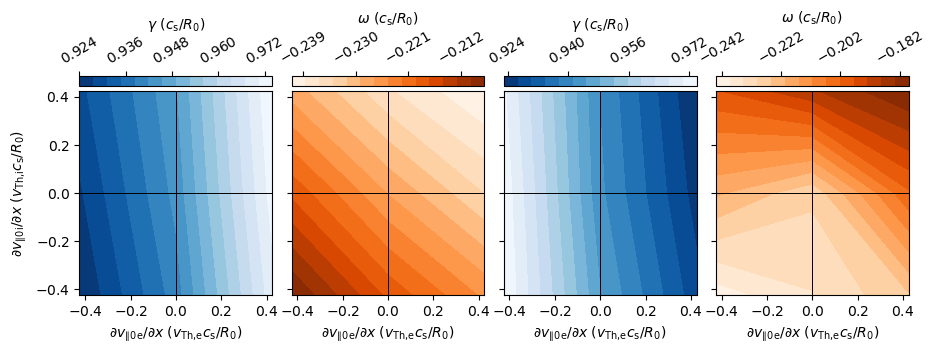

In [ ]:
# Get velocities and eigenvalues from data dictionary
V, O1 = eigenvalues['Tokamak_nTEM_ky03000_par']
_, O2 = eigenvalues['Tokamak_nTEM_ky03000_opp']
# Set levels and ticks for gamma and omega
lg1 = np.linspace(0.924,0.974,15)
tg1 = np.arange(0.924,0.974,0.012)
lo1 = np.linspace(-0.241,-0.208,15)
to1 = np.arange(-0.239,-0.208,0.009)
lg2 = np.linspace(0.923,0.974,15)
tg2 = np.arange(0.924,0.974,0.016)
lo2 = np.linspace(-0.244,-0.179,15)
to2 = np.arange(-0.242,-0.179,0.020)

# Interpolate data for clean plot
N = 3
Vi, Ve = np.mgrid[V[:,0].min():V[:,0].max():N*1j,V[:,1].min():V[:,1].max():N*1j]
gamma1 = griddata(V, O1[:,0], (Vi, Ve), method='cubic')
gamma2 = griddata(V, O2[:,0], (Vi, Ve), method='cubic')
omega1 = griddata(V, O1[:,1], (Vi, Ve), method='cubic')
omega2 = griddata(V, O2[:,1], (Vi, Ve), method='cubic')

# Create figure
fig, ax = plt.subplots(1,4,figsize=(10.7,3.2),sharey=True,gridspec_kw={'wspace':0.1})

cf = ax[0].contourf(Ve,Vi,gamma1,cmap='Blues_r',levels=lg1)
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\gamma$ ($c_\text{s}/R_0$)')
cbar.ax.set_xticks(tg1, [f"${t:.3f}$" for t in tg1], rotation=30) 

cf = ax[1].contourf(Ve,Vi,omega1,levels=lo1,cmap='Oranges')
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\omega$ ($c_\text{s}/R_0$)')
cbar.ax.set_xticks(to1, [f"${t:.3f}$" for t in to1], rotation=30) 

cf = ax[2].contourf(Ve,Vi,gamma2,cmap='Blues_r',levels=lg2)
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\gamma$ ($c_\text{s}/R_0$)')
cbar.ax.set_xticks(tg2, [f"${t:.3f}$" for t in tg2], rotation=30)  

cf = ax[3].contourf(Ve,Vi,omega2,levels=lo2,cmap='Oranges')
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\omega$ ($c_\text{s}/R_0$)')
cbar.ax.set_xticks(to2, [f"${t:.3f}$" for t in to2], rotation=30) 

ticks = np.linspace(-0.4,0.4,5)
for axi in ax:
    axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
    axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
    axi.set_xlabel(r"$\partial v_{\!\parallel\!0\text{e}}/\partial x$ ($v_\text{Th,e}c_\text{s}/R_0$)")
    axi.set_xlim(Ve.min(),Ve.max())
    axi.set_xticks(ticks,[f"${t:.1f}$" for t in ticks])

ax[0].set_ylim(Vi.min(),Vi.max())
ax[0].set_yticks(ticks,[f"${t:.1f}$" for t in ticks])
ax[0].set_ylabel(r"$\partial v_{\!\parallel\!0\text{i}}/\partial x$ ($v_\text{Th,i}c_\text{s}/R_0$)")

plt.savefig("eigenvalues_grad_tokamak_nTEM.pdf",bbox_inches='tight')

plt.show()

## Trapped-particle population cartoon

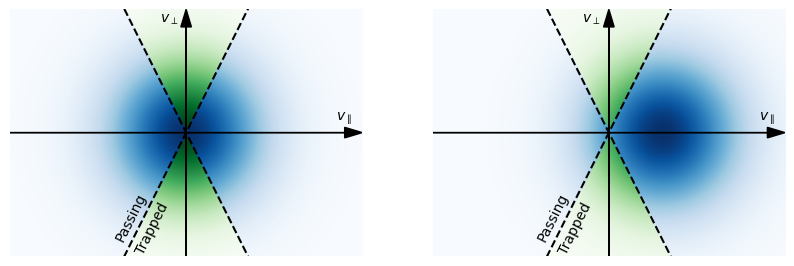

In [ ]:
x = np.linspace(-1,1,1000)
y = np.linspace(-0.7,0.7,700)
X, Y = np.meshgrid(x,y)
sigma = 0.3

fig, ax = plt.subplots(1,2,figsize=(10,5))

# Distribution
G = np.exp((-X**2-Y**2)/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
Gt = G.copy()
mask = (np.abs(X)<Y/2) + (-np.abs(X)>Y/2)
Gt[~mask] = np.nan

ax[0].imshow(G,cmap='Blues',zorder=0,origin='lower',extent=[x.min(),x.max(),y.min(),y.max()])
ax[0].imshow(Gt,cmap='Greens',zorder=0,origin='lower',extent=[x.min(),x.max(),y.min(),y.max()])

G = np.exp((-(X-0.3)**2-Y**2)/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
Gt = G.copy()
Gt[~mask] = np.nan

ax[1].imshow(G,cmap='Blues',zorder=0,origin='lower',extent=[x.min(),x.max(),y.min(),y.max()])
ax[1].imshow(Gt,cmap='Greens',zorder=0,origin='lower',extent=[x.min(),x.max(),y.min(),y.max()],vmax=G.max())

for axi in ax:
    # Trapped particle cone
    axi.plot(x,2*x,c='black',ls='--',zorder=1)
    axi.plot(x,-2*x,c='black',ls='--',zorder=1)
    axi.annotate("Passing",(-0.315,-0.63),rotation=63.4349,ha='center',va='bottom')
    axi.annotate("Trapped",(-0.19,-0.38),rotation=63.4349,ha='center',va='top')
    # Axes
    axi.arrow(-1,0,2,0,length_includes_head=True,head_length=0.1,head_width=0.06,edgecolor='black',facecolor='black')
    axi.arrow(0,-0.7,0,1.4,length_includes_head=True,head_length=0.1,head_width=0.06,edgecolor='black',facecolor='black')
    axi.annotate(r"$v_\parallel$",(0.85,0.07))
    axi.annotate(r"$v_\perp$",(-0.15,0.63))

    axi.set_xlim(x.min(),x.max())
    axi.set_ylim(y.min(),y.max())
    axi.set_xticks(ticks=[], labels=[])
    axi.set_yticks(ticks=[], labels=[])
    axi.set_aspect(1)
    axi.axis('off')

plt.savefig("trapped_particle_fraction_cartoon.pdf",bbox_inches='tight')

plt.show()

## Cross-phases

In [37]:
## Load cross-phase data from GENE simulations
modes = ["RFPTEM","TokTEM","TokITG"]
labels = ["phase","ky","time","phi_x_np","phi_x_Tppass","phi_x_Tpperp","phi_x_nt","phi_x_Ttpass","phi_x_Ttperp"]
crossphases = {}

for mode in modes:
    crossphases[mode] = {}
    for alpha in ["i","e"]:
        for key in labels[3:]:
             crossphases[mode][f'{key}_{alpha}'] = np.empty(9)
        for i in range(9):
            dat = genfromASCII(fr"cross_phases/phases{alpha}_{mode}v{i:d}.dat",labels)
            for key in labels[3:]:
                crossphases[mode][f'{key}_{alpha}'][i] = np.average(dat['phase'],weights=dat[key])

phase = dat['phase']

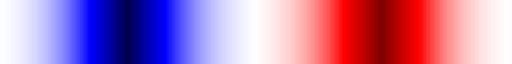

In [38]:
## Define color map for cross-phase plots
def emphasis_mapping(x, centers=[0, 0.25, 0.5, 0.75, 1], width=0.04):
    """
    Nonlinear mapping to emphasize certain regions of the colormap.
    """
    x = np.asarray(x)
    weight = np.zeros_like(x, dtype=float)
    for c in centers:
        weight += np.exp(-((x - c)**2) / (2 * width**2))
    weight /= weight.max()  # Normalize to [0,1]
    cdf = np.cumsum(weight)
    cdf = (cdf - cdf.min()) / (cdf.max() - cdf.min())
    return cdf

def cyclic_cmap_f(x,cmap='seismic',width=0.1):
    x = emphasis_mapping(x,centers=[0.25, 0.75], width=width)
    x_L = x[(0<x)*(x<=0.25)]
    x_M = x[(0.25<x)*(x<=0.75)]
    x_R = x[(0.75<x)*(x<=1)]
    if cmap[-2:] == '_r': cmap_r = cmap[:-2]
    else: cmap_r = cmap+'_r'
    c_L = colormaps[cmap_r](x_L*2+0.5)
    c_M = colormaps[cmap](x_M*2-0.5)
    c_R = colormaps[cmap_r](x_R*2-1.5)
    return np.concatenate([c_L,c_M,c_R])

colors = cyclic_cmap_f(np.linspace(0, 1, 512),'seismic',0.11)
cyclic_seismic = ListedColormap(colors, name="cyclic_seismic")
cyclic_seismic


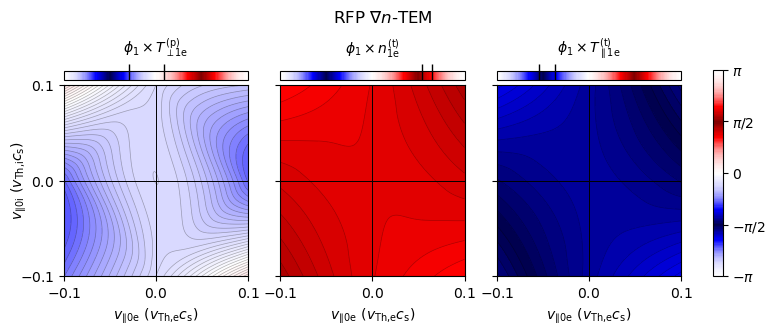

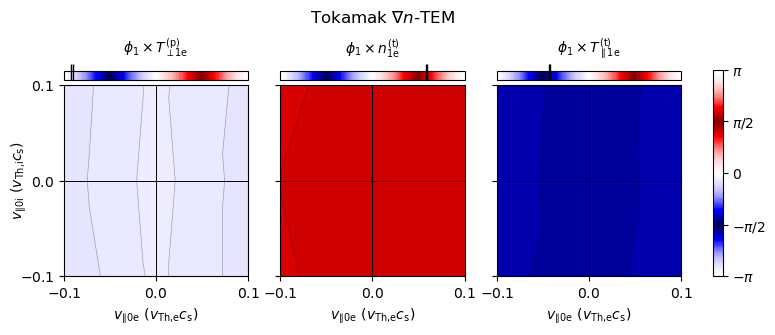

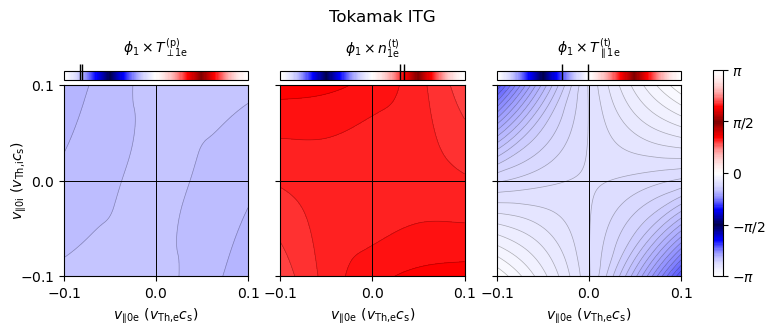

In [39]:
# Define array of all velocity points at which there is cross-phase data
V = np.array([[-0.1,-0.1],[-0.1,0.1],[0.1,-0.1],[0.1,0.1],[0.0,0.0],[-0.1,0.0],
              [0.1,0.0],[0.0,-0.1],[0.0,0.1]])
# Define velocity grid for interpolated data
N = 500
Vi, Ve = np.mgrid[V[:,0].min():V[:,0].max():N*1j,V[:,1].min():V[:,1].max():N*1j]

for mode in modes:
    # Create figure
    fig, ax = plt.subplots(1,4,figsize=(8.5,3),gridspec_kw={'wspace':0.23},width_ratios=[1,1,1,0.05])
    
    for i, key in enumerate(labels[5:8]):
        # Interpolate cross-phase data cubic or linear
        crossphase = griddata(V, crossphases[mode][f'{key}_e'], (Vi, Ve), method='cubic' if mode != 'TokTEM' else 'linear')/np.pi
        
        # Plot cross-phases
        cf = ax[i].contourf(Ve,Vi,crossphase,cmap=cyclic_seismic,levels=np.linspace(-1,1,170))
        ax[i].contour(Ve,Vi,crossphase,colors='k',alpha=0.3,linestyles='-',linewidths=0.5,levels=np.linspace(-1,1,170))

        mx, mn = crossphase.max(), crossphase.min()
        cbar = fig.colorbar(cf,ax=ax[i],orientation='horizontal',location='top',pad=0.02,label=r"$\phi_1\times$"+[r'$T^\text{(p)}_{\perp1\text{e}}$',r'$n^\text{(t)}_{1\text{e}}$',r'$T^\text{(t)}_{\parallel1\text{e}}$'][i])
        cbar_ax = cbar.ax
        cbar_ax.set_xticks([mn,mx], [], rotation=30) 
        cbar_ax.vlines([mn,mx], ymin=0, ymax=1, colors='black', linewidth=1, transform=cbar_ax.get_xaxis_transform())
        cbar_ax.tick_params(size=5,width=1)

    ticks = np.linspace(-0.1,0.1,3)
    for axi in ax[:3]:
        axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
        axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
        axi.set_xlabel(r"$v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{s}$)")
        axi.set_xlim(Ve.min(),Ve.max())
        axi.set_xticks(ticks,[f"${t:.1f}$" for t in ticks])
        axi.set_ylim(Vi.min(),Vi.max())
        axi.set_yticks(ticks,[])

    ax[0].set_ylim(Vi.min(),Vi.max())
    ax[0].set_yticks(ticks,[f"${t:.1f}$" for t in ticks])
    ax[0].set_ylabel(r"$v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}c_\text{s}$)",labelpad=-7)

    box = ax[3].get_position()
    ax[3].set_position([box.x0, box.y0, box.width, box.height * 0.895])
    cbar = plt.colorbar(cf,cax=ax[3])
    cbar.ax.set_yticks(np.linspace(-1,1,5), [r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])

    fig.suptitle({modes[0]:r"RFP $\nabla n$-TEM", modes[1]:r"Tokamak $\nabla n$-TEM", modes[2]:r"Tokamak ITG"}[mode],y=1.0)

    plt.savefig(fr"crossphases_{mode}.pdf",bbox_inches='tight')

    plt.show()

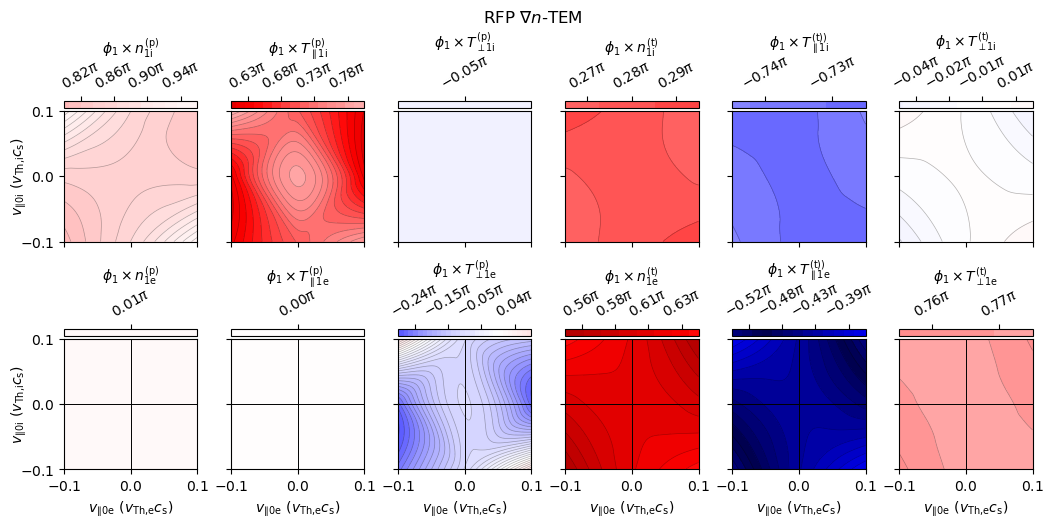

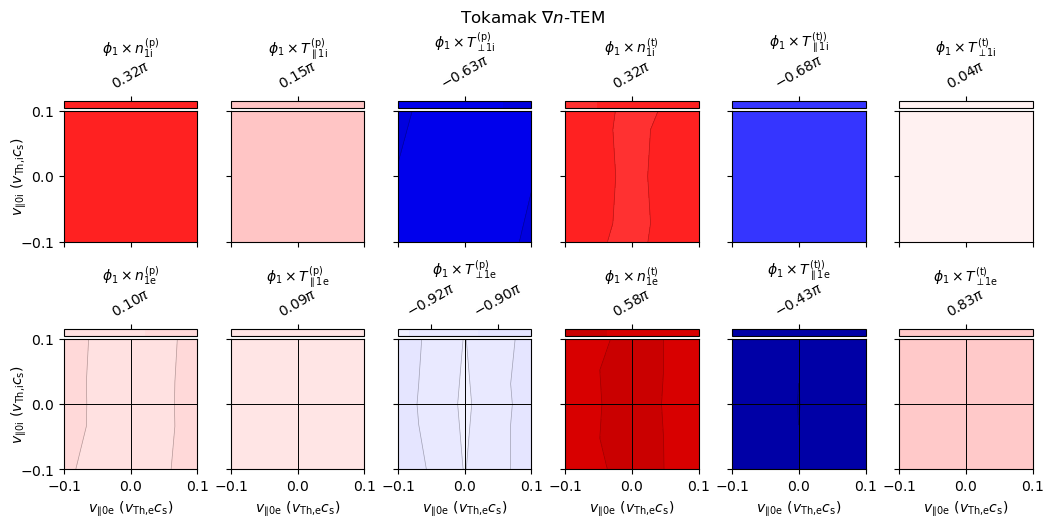

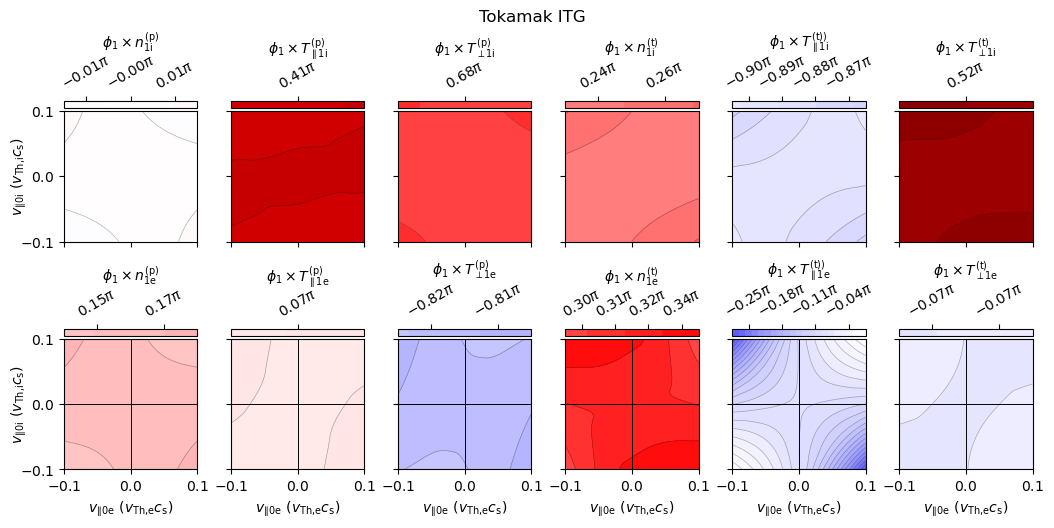

In [ ]:
## Plots of all cross-phases
# Define array of all velocity points at which there is cross-phase data, and 
# contour levels
lvs = np.linspace(-1,1,150)
V = np.array([[-0.1,-0.1],[-0.1,0.1],[0.1,-0.1],[0.1,0.1],[0.0,0.0],[-0.1,0.0],[0.1,0.0],[0.0,-0.1],[0.0,0.1]])
# Define velocity grid for interpolated data
N = 500
Vi, Ve = np.mgrid[V[:,0].min():V[:,0].max():N*1j,V[:,1].min():V[:,1].max():N*1j]
# Labels for plots
labs = {
    'e': [r'$n^\text{(p)}_{1\text{e}}$',r'$T^\text{(p)}_{\parallel1\text{e}}$',r'$T^\text{(p)}_{\perp1\text{e}}$',r'$n^\text{(t)}_{1\text{e}}$',r'$T^\text{(t))}_{\parallel1\text{e}}$',r'$T^\text{(t)}_{\perp1\text{e}}$'],
    'i': [r'$n^\text{(p)}_{1\text{i}}$',r'$T^\text{(p)}_{\parallel1\text{i}}$',r'$T^\text{(p)}_{\perp1\text{i}}$',r'$n^\text{(t)}_{1\text{i}}$',r'$T^\text{(t))}_{\parallel1\text{i}}$',r'$T^\text{(t)}_{\perp1\text{i}}$']
}
for mode in modes:
    # Create figure
    fig, ax = plt.subplots(2,6,figsize=(12.5,5),sharey=True,sharex=True,gridspec_kw={'wspace':0.25,'hspace':0.45})
    
    for j, alpha in enumerate(["i","e"]):
        for i, key in enumerate(labels[3:]):
            # Interpolate cross-phase data cubic or linear
            crossphase = griddata(V, crossphases[mode][f'{key}_{alpha}'], (Vi, Ve), method='cubic' if mode != 'TokTEM' else 'linear')/np.pi

            mx, mn = crossphase.max(), crossphase.min()
            l = 1+int(np.ceil(len(lvs)/2*(mx-mn)))
            ticks = np.linspace(mn,mx,5 if l>=5 else l)
            ticks = (ticks[1:]+ticks[:-1])/2

            # Plot cross-phases
            cf = ax[j,i].contourf(Ve,Vi,crossphase,cmap=cyclic_seismic,levels=lvs)
            ax[j,i].contour(Ve,Vi,crossphase,colors='k',alpha=0.3,linewidths=0.5,linestyles='-',levels=lvs)
            cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\phi_1\times$'+labs[alpha][i])
            cbax = cbar.ax
            cbax.set_xticks(ticks, [fr"${t:.2f}\pi$" for t in ticks], rotation=30) 
            cbax.set_xlim(mn,mx)

    ticks = np.linspace(-0.1,0.1,3)
    for axi in ax[1,:]:
        axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
        axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
        axi.set_xlabel(r"$v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{s}$)")
        axi.set_xlim(Ve.min(),Ve.max())
        axi.set_xticks(ticks,[f"${t:.1f}$" for t in ticks])

    for j in range(2):
        ax[j,0].set_ylim(Vi.min(),Vi.max())
        ax[j,0].set_yticks(ticks,[f"${t:.1f}$" for t in ticks])
        ax[j,0].set_ylabel(r"$v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}c_\text{s}$)",labelpad=-7)

    fig.suptitle({modes[0]:r"RFP $\nabla n$-TEM", modes[1]:r"Tokamak $\nabla n$-TEM", modes[2]:r"Tokamak ITG"}[mode],y=1.03)

    plt.savefig(fr"crossphases_{mode}_extra.pdf",bbox_inches='tight')
    
    plt.show()

## Microinstability cartoons

In [30]:
def arrow_patch(x,y,length=1.,width=1.,head_length=0.,head_width=0.,
    overhang=0.,length_includes_head=True,clip_on=False,**kwargs):
    # ha=left, va=center
    L = length; W = width
    Lh = head_length; Wh = head_width
    if length_includes_head: L -= Lh
    O = overhang*Lh/2 if 0<=overhang<=1 else 0
    points = [
        [x,y-W/2],
        [x,y+W/2],
        [x+L+O,y+W/2],
        [x+L,y+Wh/2],
        [x+L+Lh,y],
        [x+L,y-Wh/2],
        [x+L+O,y-W/2]
    ]
    arrow = Polygon(points,closed=True,clip_on=clip_on,**kwargs)
    return arrow

### Drift wave

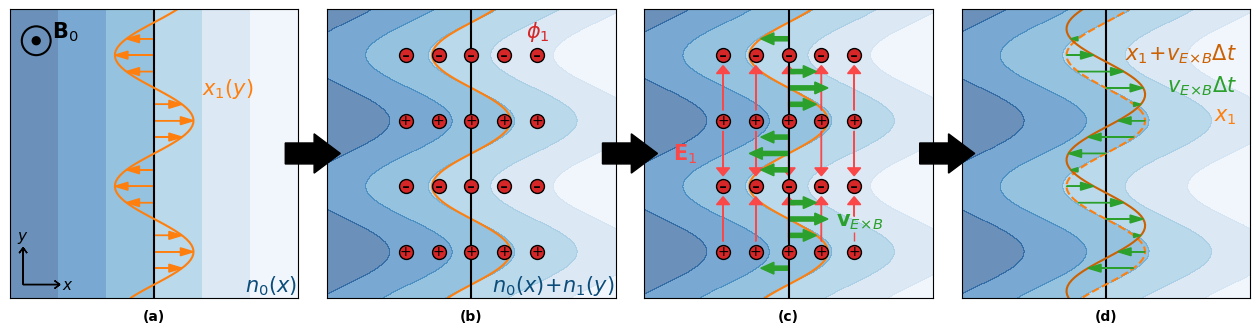

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(16,4), gridspec_kw=dict(wspace=0.1,width_ratios=[1,1,1,1]))

N = 100
Lx = 1
Ly = 4*np.pi
x_buf = 0.1*Lx
y_buf = 0.1*Ly
n0 = 1
levels = np.linspace(0,n0,7)
dn = 0.15
dndx = -1
phase = 0.4*np.pi
arrow_tip_length = 0.05
arrow_tip_width = 0.03
fontsize = 15
fontsize_superscript = 11
n_color = 'Blues'
n_text_color = '#0b4c7a'
dx_color = 'C1'
dx_new_color = '#cc6102'#'#612000'
phi_color = 'C3'
E_color = '#fa4849'
ExB_color = 'C2'

x, y = np.mgrid[-Lx/2-x_buf/2:Lx/2+x_buf/2:N*1j,-Ly/2-y_buf/2:Ly/2+y_buf/2:N*1j]
n0x = n0*(1-np.linspace([0,]*N,[1,]*N,N))
dny = lambda yi: dn*np.sin(yi)
nxy = n0x+dny(y); nxy -= nxy.min(); nxy /= nxy.max() 
dxy = lambda yi: -dny(yi)/dndx
dxy_new = lambda yi: -dn*np.sin(yi-phase)/dndx
ExB = lambda yi: -dn*np.cos(yi)
yarrow = np.arange(-7,8)*Ly/16

ax[0].contourf(x,y,n0x,levels=levels,cmap=n_color,alpha=0.6,zorder=-10)
ax[0].plot(dxy(y[0]),y[0],c=dx_color,zorder=1);
for yi in yarrow:
    mod = 1
    if np.abs(dxy(yi)) < arrow_tip_length*Lx: 
        mod = np.abs(dxy(yi))/(arrow_tip_length*Lx)
    ax[0].arrow(0,yi,dxy(yi),0,head_width=mod*arrow_tip_width*Ly,head_length=mod*arrow_tip_length*Lx,length_includes_head=True,color=dx_color,zorder=-1)

ax[0].arrow(-0.5*Lx,-0.5*Ly,0.14*Lx,0,color='black',overhang=1,head_width=0.03*Ly,head_length=0.02*Lx,length_includes_head=True)
ax[0].arrow(-0.5*Lx,-0.5*Ly,0,0.14*Ly,color='black',overhang=1,head_width=0.03*Lx,head_length=0.02*Ly,length_includes_head=True)
ax[0].annotate(r"$x$",(-0.35*Lx,-0.5*Ly),va='center',ha='left',fontsize=fontsize_superscript,c='black',zorder=10)
ax[0].annotate(r"$y$",(-0.5*Lx,-0.35*Ly),va='bottom',ha='center',fontsize=fontsize_superscript,c='black',zorder=10)

ax[1].contourf(x,y,nxy,levels=levels,cmap=n_color,alpha=0.6,zorder=-10)
ax[1].plot(dxy(y[0]),y[0],c=dx_color,zorder=-2);
cx, cy = np.mgrid[-Lx/4:Lx/4:5j,-3/8*Ly:3/8*Ly:4j]
ax[1].scatter(cx,cy,c=phi_color,s=100,edgecolor='black',zorder=5)
for i,(xp,yp,xm,ym) in enumerate(zip(cx[:,::2].flatten(),cy[:,::2].flatten(),cx[:,1::2].flatten(),cy[:,1::2].flatten())):
    ax[1].annotate('+',(xp,yp),ha='center',va='center',zorder=10)
    ax[1].annotate('-',(xm,ym+0.02),ha='center',va='center',fontsize=16,zorder=10)

ax[2].contourf(x,y,nxy,levels=levels,cmap=n_color,alpha=0.6,zorder=-10)
ax[2].plot(dxy(y[0]),y[0],c=dx_color,zorder=-2);
cx, cy = np.mgrid[-Lx/4:Lx/4:5j,-3/8*Ly:3/8*Ly:4j]
ax[2].scatter(cx,cy,c=phi_color,s=100,edgecolor='black',zorder=5)
for i,(xp,yp,xm,ym) in enumerate(zip(cx[:,::2].flatten(),cy[:,::2].flatten(),cx[:,1::2].flatten(),cy[:,1::2].flatten())):
    ax[2].annotate('+',(xp,yp),ha='center',va='center',zorder=10)
    ax[2].annotate('-',(xm,ym+0.02),ha='center',va='center',fontsize=16,zorder=10)
    if i!=8:
        ax[2].arrow(xp,yp+0.04*Ly,xm-xp,ym-yp-0.08*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-2)
    else:
        ax[2].arrow(xp,yp+0.04*Ly,xm-xp,-0.34*Ly-yp,head_length=0,head_width=0,color=E_color,zorder=-2)
        ax[2].arrow(xp,-0.24*Ly,xm-xp,ym+0.20*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)

for xp,yp,xm,ym in zip(cx[:,1],cy[:,1],cx[:,2],cy[:,2]):
    ax[2].arrow(xm,ym-0.04*Ly,xp-xm,yp-ym+0.08*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)

for yi in yarrow:
    mod = 1
    if np.abs(ExB(yi)) < arrow_tip_length*Lx: 
        mod = np.abs(ExB(yi))/(arrow_tip_length*Lx)
    if np.round(mod,5) != 0:
        ax[2].arrow(0,yi,ExB(yi),0,head_width=mod*arrow_tip_width*Ly*1.5,head_length=mod*arrow_tip_length*Lx,length_includes_head=True,color='C2',width=0.2,zorder=-1)

ax[3].contourf(x,y,nxy,levels=levels,cmap=n_color,alpha=0.6,zorder=-10)
ax[3].plot(dxy(y[0]),y[0],c=dx_color,ls='--',zorder=1)
ax[3].plot(dxy_new(y[0]),y[0],c=dx_new_color,zorder=2)
for yi in yarrow:
    dr = dxy_new(yi)-dxy(yi)
    mod = 1
    if np.abs(dr) < arrow_tip_length*Lx: 
        mod = np.abs(dr)/(arrow_tip_length*Lx)
    ax[3].arrow(dxy(yi),yi,dr,0,head_width=mod*arrow_tip_width*Ly,head_length=mod*arrow_tip_length*Lx,length_includes_head=True,color='C2',zorder=3)


ax[0].annotate(r"$n_0(x)$",(0.545*Lx,-0.55*Ly),va='bottom',ha='right',fontsize=fontsize,c=n_text_color,zorder=10)
ax[1].annotate(r"$n_0(x)\!+\!n_1(y)$",(0.545*Lx,-0.55*Ly),va='bottom',ha='right',fontsize=fontsize,c=n_text_color,zorder=10)
# dx
ax[0].annotate(r"$x_1(y)$",(0.38*Lx,0.25*Ly),va='center',ha='right',fontsize=fontsize,c=dx_color,zorder=10)
ax[3].annotate(r"$x_1$",(0.5*Lx,0.14*Ly),va='center',ha='right',fontsize=fontsize,c=dx_color,zorder=10)
ax[3].annotate(r"$x_1\!+\!v_{E\!\times\!B}\Delta t$",(0.5*Lx,0.38*Ly),va='center',ha='right',fontsize=fontsize,c=dx_new_color,zorder=10)
# phi, E
ax[1].annotate(r"$\phi_1$",(0.3*Lx,0.51*Ly),va='top',ha='right',fontsize=fontsize,c=phi_color,zorder=10)
ax[2].annotate(r"$\mathbf{E}_1$",(-0.35*Lx,0),va='center',ha='right',fontsize=fontsize,c=E_color,zorder=10)
# B
ax[0].add_patch(Ellipse((-0.45*Lx, 0.43*Ly),0.11*Lx,0.11*Ly,color='black',fill=False,lw=1.5))
ax[0].add_patch(Ellipse((-0.45*Lx, 0.43*Ly),0.03*Lx,0.03*Ly,color='black'))
ax[0].annotate(r"$\mathbf{B}_0$",(-0.39*Lx,0.42*Ly),va='bottom',ha='left',c='black',fontsize=fontsize)
# ExB
ax[2].annotate(r"$\mathbf{v}_{E\!\times\!B}$",(0.27*Lx,-0.26*Ly),va='center',ha='center',fontsize=fontsize,c=ExB_color,zorder=10)
ax[3].annotate(r"$v_{E\!\times\!B}\Delta t$",(0.5*Lx,0.26*Ly),va='center',ha='right',fontsize=fontsize,c=ExB_color,zorder=10)

for axi in ax:
    axi.axvline(0,c='black',zorder=0)

    axi.set_xticks(ticks=[], labels=[])
    axi.set_yticks(ticks=[], labels=[])
    axi.set_aspect(Lx/Ly)

ax[3].add_patch(arrow_patch(-3.13*Lx,0,0.21*Lx,0.08*Ly,0.1*Lx,0.15*Ly,color='black',zorder=20))
ax[3].add_patch(arrow_patch(-1.92*Lx,0,0.21*Lx,0.08*Ly,0.1*Lx,0.15*Ly,color='black',zorder=20))
ax[3].add_patch(arrow_patch(-0.71*Lx,0,0.21*Lx,0.08*Ly,0.1*Lx,0.15*Ly,color='black',zorder=20))
for i,s in enumerate('abcd'):
    ax[i].text(0.,-Ly*0.62,f'({s})',fontsize=10,weight='bold',va='center',ha='center',clip_on=False)

plt.savefig("cartoon_dw.pdf",bbox_inches='tight')

plt.show()

### TPM

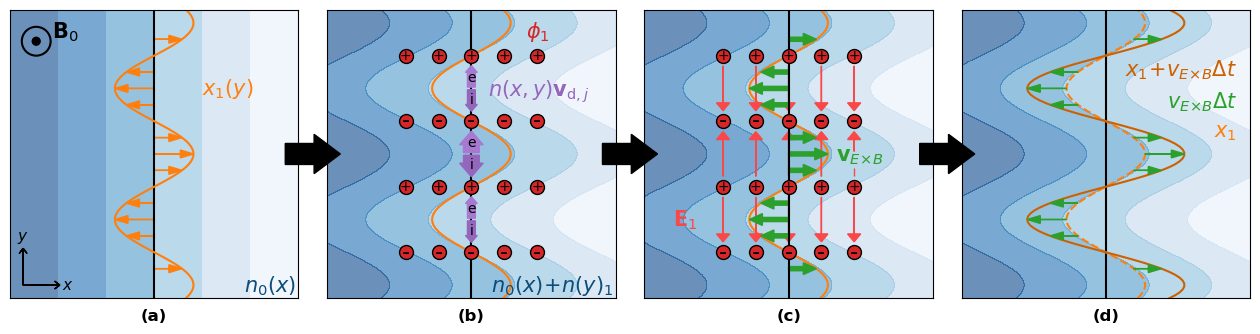

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(16,4), gridspec_kw=dict(wspace=0.1,width_ratios=[1,1,1,1]))

N = 100
Lx = 1
Ly = 4*np.pi
x_buf = 0.1*Lx
y_buf = 0.1*Ly
n0 = 1
levels = np.linspace(0,n0,7)
dn = 0.15
dndx = -1
scale = 2
arrow_tip_length = 0.05
arrow_tip_width = 0.03
fontsize = 15
fontsize_superscript = 11
n_color = 'Blues'
n_text_color = '#0b4c7a'
dx_color = 'C1'
dx_new_color = '#cc6102'#'#612000'
vde_color = '#a779d1'
vdi_color = 'C4'
phi_color = 'C3'
E_color = '#fa4849'
ExB_color = 'C2'

x, y = np.mgrid[-Lx/2-x_buf/2:Lx/2+x_buf/2:N*1j,-Ly/2-y_buf/2:Ly/2+y_buf/2:N*1j]
n0x = n0*(1-np.linspace([0,]*N,[1,]*N,N))
dny = lambda yi: dn*np.cos(yi)
nxy = n0x+dny(y); nxy -= nxy.min(); nxy /= nxy.max() 
dxy = lambda yi: -dny(yi)/dndx
dxy_new = lambda yi: dxy(yi)*scale
ExB = lambda yi: dn*np.cos(yi)
yarrow = np.arange(-7,8)*Ly/16

ax[0].contourf(x,y,n0x,levels=levels,cmap=n_color,alpha=0.6,zorder=-10)
ax[0].plot(dxy(y[0]),y[0],c=dx_color,zorder=1);
for yi in yarrow:
    mod = 1
    if np.abs(dxy(yi)) < arrow_tip_length*Lx: 
        mod = np.abs(dxy(yi))/(arrow_tip_length*Lx)
    ax[0].arrow(0,yi,dxy(yi),0,head_width=mod*arrow_tip_width*Ly,head_length=mod*arrow_tip_length*Lx,length_includes_head=True,color=dx_color,zorder=-1)

ax[0].arrow(-0.5*Lx,-0.5*Ly,0.14*Lx,0,color='black',overhang=1,head_width=0.03*Ly,head_length=0.02*Lx,length_includes_head=True)
ax[0].arrow(-0.5*Lx,-0.5*Ly,0,0.14*Ly,color='black',overhang=1,head_width=0.03*Lx,head_length=0.02*Ly,length_includes_head=True)
ax[0].annotate(r"$x$",(-0.35*Lx,-0.5*Ly),va='center',ha='left',fontsize=fontsize_superscript,c='black',zorder=10)
ax[0].annotate(r"$y$",(-0.5*Lx,-0.35*Ly),va='bottom',ha='center',fontsize=fontsize_superscript,c='black',zorder=10)

ax[1].contourf(x,y,nxy,levels=levels,cmap=n_color,alpha=0.6,zorder=-10)
ax[1].plot(dxy(y[0]),y[0],c=dx_color,zorder=-2);
cx, cy = np.mgrid[-Lx/4:Lx/4:5j,-3/8*Ly:3/8*Ly:4j]
ax[1].scatter(cx,cy,c=phi_color,s=100,edgecolor='black',zorder=5)
for i,(xm,ym,xp,yp) in enumerate(zip(cx[:,::2].flatten(),cy[:,::2].flatten(),cx[:,1::2].flatten(),cy[:,1::2].flatten())):
    ax[1].annotate('+',(xp,yp),ha='center',va='center',zorder=10)
    ax[1].annotate('-',(xm,ym+0.02),ha='center',va='center',fontsize=16,zorder=10)
for i, yi in enumerate(np.linspace(-1/4,1/4,3)*Ly):
    if i % 2: mod = 1
    else: mod = 0.5
    ax[1].arrow(0,yi-0.005*Ly,0,-0.082*Ly,width=0.06*Lx*mod,head_length=0.052*Ly*mod,head_width=0.09*Lx*mod,length_includes_head=True,color=vdi_color,zorder=2)
    ax[1].arrow(0,yi+0.005*Ly,0,0.082*Ly,width=0.06*Lx*mod,head_length=0.052*Ly*mod,head_width=0.09*Lx*mod,length_includes_head=True,color=vde_color,zorder=2)
    ax[1].annotate(r"i",(0,yi-0.015*Ly),va='top',ha='center',fontsize=fontsize_superscript-1,zorder=10)
    ax[1].annotate(r"e",(0,yi+0.015*Ly),va='bottom',ha='center',fontsize=fontsize_superscript-1,zorder=10)


ax[2].contourf(x,y,nxy,levels=levels,cmap=n_color,alpha=0.6,zorder=-10)
ax[2].plot(dxy(y[0]),y[0],c=dx_color,zorder=-2);
ax[2].scatter(cx,cy,c=phi_color,s=100,edgecolor='black',zorder=5)
for xm,ym,xp,yp in zip(cx[:,::2].flatten(),cy[:,::2].flatten(),cx[:,1::2].flatten(),cy[:,1::2].flatten()):
    ax[2].annotate('+',(xp,yp),ha='center',va='center',zorder=10)
    ax[2].annotate('-',(xm,ym+0.02),ha='center',va='center',fontsize=16,zorder=10)
for i, cxi in enumerate(cx[:,0]):
    if i != 4:
        ax[2].arrow(cxi,cy[i,1]+0.04*Ly,0,cy[i,2]-cy[i,1]-0.08*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)
    else:
        ax[2].arrow(cxi,cy[i,2]-0.115*Ly,0,0.075*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)
        ax[2].arrow(cxi,cy[i,1]+0.04*Ly,0,0.033*Ly,head_length=0,head_width=0,color=E_color,zorder=-1)
    ax[2].arrow(cxi,cy[i,1]-0.04*Ly,0,cy[i,0]-cy[i,1]+0.08*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)
    ax[2].arrow(cxi,cy[i,3]-0.04*Ly,0,cy[i,2]-cy[i,3]+0.08*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)
for yi in yarrow:
    mod = 1
    if np.abs(ExB(yi)) < arrow_tip_length*Lx: 
        mod = np.abs(ExB(yi))/(arrow_tip_length*Lx)
    if np.round(mod,5) != 0:
        ax[2].arrow(0,yi,ExB(yi),0,head_width=mod*arrow_tip_width*Ly*1.5,head_length=mod*arrow_tip_length*Lx,length_includes_head=True,color='C2',width=0.2,zorder=-1)


ax[3].contourf(x,y,nxy,levels=levels,cmap=n_color,alpha=0.6,zorder=-10)
ax[3].plot(dxy(y[0]),y[0],c=dx_color,ls='--',zorder=1)
ax[3].plot(dxy_new(y[0]),y[0],c=dx_new_color,zorder=2)
for yi in yarrow:
    dr = dxy_new(yi)-dxy(yi)
    mod = 1
    if np.abs(dr) < arrow_tip_length*Lx: 
        mod = np.abs(dr)/(arrow_tip_length*Lx)
    ax[3].arrow(dxy(yi),yi,dr,0,head_width=mod*arrow_tip_width*Ly,head_length=mod*arrow_tip_length*Lx,length_includes_head=True,color='C2',zorder=3)


# n
ax[0].annotate(r"$n_0(x)$",(0.54*Lx,-0.55*Ly),va='bottom',ha='right',fontsize=fontsize,c=n_text_color,zorder=10)
ax[1].annotate(r"$n_0(x)\!+\!n(y)_1$",(0.54*Lx,-0.55*Ly),va='bottom',ha='right',fontsize=fontsize,c=n_text_color,zorder=10)
# dx
ax[0].annotate(r"$x_1(y)$",(0.38*Lx,0.25*Ly),va='center',ha='right',fontsize=fontsize,c=dx_color,zorder=10)
ax[3].annotate(r"$x_1$",(0.5*Lx,0.08*Ly),va='center',ha='right',fontsize=fontsize,c=dx_color,zorder=10)
ax[3].annotate(r"$x_1\!+\!v_{E\!\times\!B}\Delta t$",(0.5*Lx,0.32*Ly),va='center',ha='right',fontsize=fontsize,c=dx_new_color,zorder=10)
# drift
ax[1].annotate(r"$n(x,y)\mathbf{v}_{\text{d},j}$",(0.45*Lx,0.29*Ly),va='top',ha='right',fontsize=fontsize,c=vdi_color,zorder=10)
# phi, E
ax[1].annotate(r"$\phi_1$",(0.3*Lx,0.51*Ly),va='top',ha='right',fontsize=fontsize,c=phi_color,zorder=10)
ax[2].annotate(r"$\mathbf{E}_1$",(-0.35*Lx,-0.25*Ly),va='center',ha='right',fontsize=fontsize,c=E_color,zorder=10)
# B
ax[0].add_patch(Ellipse((-0.45*Lx, 0.43*Ly),0.11*Lx,0.11*Ly,color='black',fill=False,lw=1.5))
ax[0].add_patch(Ellipse((-0.45*Lx, 0.43*Ly),0.03*Lx,0.03*Ly,color='black'))
ax[0].annotate(r"$\mathbf{B}_0$",(-0.39*Lx,0.42*Ly),va='bottom',ha='left',c='black',fontsize=fontsize)
# ExB
ax[2].annotate(r"$\mathbf{v}_{E\!\times\!B}$",(0.27*Lx,-0.01*Ly),va='center',ha='center',fontsize=fontsize,c=ExB_color,zorder=10)
ax[3].annotate(r"$v_{E\!\times\!B}\Delta t$",(0.5*Lx,0.2*Ly),va='center',ha='right',fontsize=fontsize,c=ExB_color,zorder=10)


for axi in ax:
    axi.axvline(0,c='black',zorder=0)

    axi.set_xticks(ticks=[], labels=[])
    axi.set_yticks(ticks=[], labels=[])
    axi.set_aspect(Lx/Ly)

ax[3].add_patch(arrow_patch(-3.13*Lx,0,0.21*Lx,0.08*Ly,0.1*Lx,0.15*Ly,color='black',zorder=20))
ax[3].add_patch(arrow_patch(-1.92*Lx,0,0.21*Lx,0.08*Ly,0.1*Lx,0.15*Ly,color='black',zorder=20))
ax[3].add_patch(arrow_patch(-0.71*Lx,0,0.21*Lx,0.08*Ly,0.1*Lx,0.15*Ly,color='black',zorder=20))
for i,s in enumerate('abcd'):
    ax[i].text(0.,-Ly*0.62,f'({s})',fontsize=12,weight='bold',va='center',ha='center',clip_on=False)

plt.savefig("cartoon_tpm.pdf",bbox_inches='tight')

plt.show()

### ETG

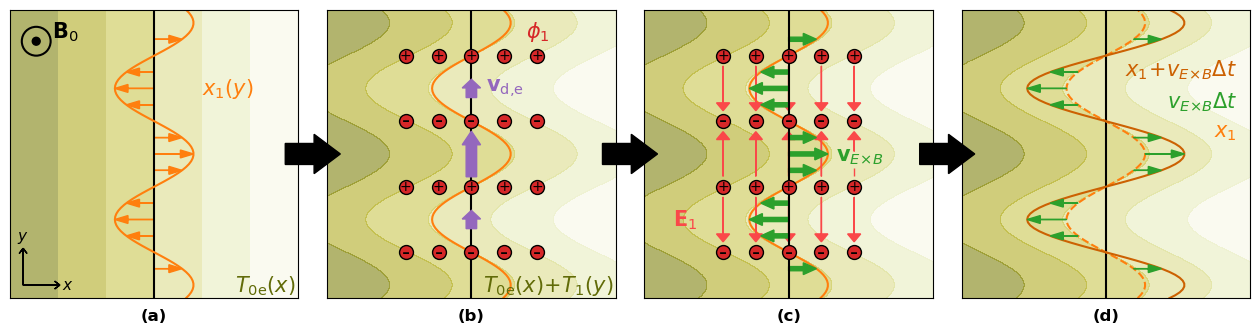

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(16,4), gridspec_kw=dict(wspace=0.1,width_ratios=[1,1,1,1]))

N = 100
Lx = 1
Ly = 4*np.pi
x_buf = 0.1*Lx
y_buf = 0.1*Ly
T0 = 1
levels = np.linspace(0,T0,7)
dT = 0.15
dTdx = 1
scale = 2
arrow_tip_length = 0.05
arrow_tip_width = 0.03
fontsize = 15
fontsize_superscript = 11
T_color = LinearSegmentedColormap.from_list("Yellows", ['#fffdf7','#ebf2d0','#dedf94','#c9c54a','#aba617','#616b08'])
T_text_color = '#616b08'
dx_color = 'C1'
dx_new_color = '#cc6102'
vd_color = 'C4'
phi_color = 'C3'
E_color = '#fa4849'
ExB_color = 'C2'

x, y = np.mgrid[-Lx/2-x_buf/2:Lx/2+x_buf/2:N*1j,-Ly/2-y_buf/2:Ly/2+y_buf/2:N*1j]
T0x = T0*(1-np.linspace([0,]*N,[1,]*N,N))
dTy = lambda yi: dT*np.cos(yi)
Txy = T0x+dTy(y); Txy -= Txy.min(); Txy /= Txy.max() 
dxy = lambda yi: dTy(yi)/dTdx
dxy_new = lambda yi: dxy(yi)*scale
ExB = lambda yi: dT*np.cos(yi)
yarrow = np.arange(-7,8)*Ly/16

ax[0].contourf(x,y,T0x,levels=levels,cmap=T_color,alpha=0.6,zorder=-10)
ax[0].plot(dxy(y[0]),y[0],c=dx_color,zorder=1);
for yi in yarrow:
    mod = 1
    if np.abs(dxy(yi)) < arrow_tip_length*Lx: 
        mod = np.abs(dxy(yi))/(arrow_tip_length*Lx)
    ax[0].arrow(0,yi,dxy(yi),0,head_width=mod*arrow_tip_width*Ly,head_length=mod*arrow_tip_length*Lx,length_includes_head=True,color=dx_color,zorder=-1)

ax[0].arrow(-0.5*Lx,-0.5*Ly,0.14*Lx,0,color='black',overhang=1,head_width=0.03*Ly,head_length=0.02*Lx,length_includes_head=True)
ax[0].arrow(-0.5*Lx,-0.5*Ly,0,0.14*Ly,color='black',overhang=1,head_width=0.03*Lx,head_length=0.02*Ly,length_includes_head=True)
ax[0].annotate(r"$x$",(-0.35*Lx,-0.5*Ly),va='center',ha='left',fontsize=fontsize_superscript,c='black',zorder=10)
ax[0].annotate(r"$y$",(-0.5*Lx,-0.35*Ly),va='bottom',ha='center',fontsize=fontsize_superscript,c='black',zorder=10)

ax[1].contourf(x,y,Txy,levels=levels,cmap=T_color,alpha=0.6,zorder=-10)
ax[1].plot(dxy(y[0]),y[0],c=dx_color,zorder=-2);
cx, cy = np.mgrid[-Lx/4:Lx/4:5j,-3/8*Ly:3/8*Ly:4j]
ax[1].scatter(cx,cy,c=phi_color,s=100,edgecolor='black',zorder=5)
for i,(xm,ym,xp,yp) in enumerate(zip(cx[:,::2].flatten(),cy[:,::2].flatten(),cx[:,1::2].flatten(),cy[:,1::2].flatten())):
    ax[1].annotate('+',(xp,yp),ha='center',va='center',zorder=10)
    ax[1].annotate('-',(xm,ym+0.02),ha='center',va='center',fontsize=16,zorder=10)
for i, yi in enumerate(np.linspace(-1/4,1/4,3)*Ly):
    if i % 2: mod = 1
    else: mod = 0.4
    ax[1].arrow(0,yi-0.087*Ly*mod,0,0.174*Ly*mod,width=0.04*Lx,head_length=0.052*Ly*np.sqrt(mod),head_width=0.07*Lx,length_includes_head=True,color=vd_color,zorder=2)

ax[2].contourf(x,y,Txy,levels=levels,cmap=T_color,alpha=0.6,zorder=-10)
ax[2].plot(dxy(y[0]),y[0],c=dx_color,zorder=-2);
ax[2].scatter(cx,cy,c=phi_color,s=100,edgecolor='black',zorder=5)
for xm,ym,xp,yp in zip(cx[:,::2].flatten(),cy[:,::2].flatten(),cx[:,1::2].flatten(),cy[:,1::2].flatten()):
    ax[2].annotate('+',(xp,yp),ha='center',va='center',zorder=10)
    ax[2].annotate('-',(xm,ym+0.02),ha='center',va='center',fontsize=16,zorder=10)
for i, cxi in enumerate(cx[:,0]):
    if i != 4:
        ax[2].arrow(cxi,cy[i,1]+0.04*Ly,0,cy[i,2]-cy[i,1]-0.08*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)
    else:
        ax[2].arrow(cxi,cy[i,2]-0.115*Ly,0,0.075*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)
        ax[2].arrow(cxi,cy[i,1]+0.04*Ly,0,0.033*Ly,head_length=0,head_width=0,color=E_color,zorder=-1)
    ax[2].arrow(cxi,cy[i,1]-0.04*Ly,0,cy[i,0]-cy[i,1]+0.08*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)
    ax[2].arrow(cxi,cy[i,3]-0.04*Ly,0,cy[i,2]-cy[i,3]+0.08*Ly,head_length=arrow_tip_width*Ly,head_width=arrow_tip_length*Lx,length_includes_head=True,color=E_color,zorder=-1)
for yi in yarrow:
    mod = 1
    if np.abs(ExB(yi)) < arrow_tip_length*Lx: 
        mod = np.abs(ExB(yi))/(arrow_tip_length*Lx)
    if np.round(mod,5) != 0:
        ax[2].arrow(0,yi,ExB(yi),0,head_width=mod*arrow_tip_width*Ly*1.5,head_length=mod*arrow_tip_length*Lx,length_includes_head=True,color='C2',width=0.2,zorder=-1)


ax[3].contourf(x,y,Txy,levels=levels,cmap=T_color,alpha=0.6,zorder=-10)
ax[3].plot(dxy(y[0]),y[0],c=dx_color,ls='--',zorder=1)
ax[3].plot(dxy_new(y[0]),y[0],c=dx_new_color,zorder=2)
for yi in yarrow:
    dr = dxy_new(yi)-dxy(yi)
    mod = 1
    if np.abs(dr) < arrow_tip_length*Lx: 
        mod = np.abs(dr)/(arrow_tip_length*Lx)
    ax[3].arrow(dxy(yi),yi,dr,0,head_width=mod*arrow_tip_width*Ly,head_length=mod*arrow_tip_length*Lx,length_includes_head=True,color='C2',zorder=3)


# n
ax[0].annotate(r"$T_{0\text{e}}(x)$",(0.54*Lx,-0.55*Ly),va='bottom',ha='right',fontsize=fontsize,c=T_text_color,zorder=10)
ax[1].annotate(r"$T_{0\text{e}}(x)\!+\!T_1(y)$",(0.54*Lx,-0.55*Ly),va='bottom',ha='right',fontsize=fontsize,c=T_text_color,zorder=10)
# dx
ax[0].annotate(r"$x_1(y)$",(0.38*Lx,0.25*Ly),va='center',ha='right',fontsize=fontsize,c=dx_color,zorder=10)
ax[3].annotate(r"$x_1$",(0.5*Lx,0.08*Ly),va='center',ha='right',fontsize=fontsize,c=dx_color,zorder=10)
ax[3].annotate(r"$x_1\!+\!v_{E\!\times\!B}\Delta t$",(0.5*Lx,0.32*Ly),va='center',ha='right',fontsize=fontsize,c=dx_new_color,zorder=10)
# drift
ax[1].annotate(r"$\mathbf{v}_\text{d,e}$",(0.2*Lx,0.29*Ly),va='top',ha='right',fontsize=fontsize,c=vd_color,zorder=10)
# phi, E
ax[1].annotate(r"$\phi_1$",(0.3*Lx,0.51*Ly),va='top',ha='right',fontsize=fontsize,c=phi_color,zorder=10)
ax[2].annotate(r"$\mathbf{E}_1$",(-0.35*Lx,-0.25*Ly),va='center',ha='right',fontsize=fontsize,c=E_color,zorder=10)
# B
ax[0].add_patch(Ellipse((-0.45*Lx, 0.43*Ly),0.11*Lx,0.11*Ly,color='black',fill=False,lw=1.5))
ax[0].add_patch(Ellipse((-0.45*Lx, 0.43*Ly),0.03*Lx,0.03*Ly,color='black'))
ax[0].annotate(r"$\mathbf{B}_0$",(-0.39*Lx,0.42*Ly),va='bottom',ha='left',c='black',fontsize=fontsize)
# ExB
ax[2].annotate(r"$\mathbf{v}_{E\!\times\!B}$",(0.27*Lx,-0.01*Ly),va='center',ha='center',fontsize=fontsize,c=ExB_color,zorder=10)
ax[3].annotate(r"$v_{E\!\times\!B}\Delta t$",(0.5*Lx,0.2*Ly),va='center',ha='right',fontsize=fontsize,c=ExB_color,zorder=10)


for axi in ax:
    axi.axvline(0,c='black',zorder=0)

    axi.set_xticks(ticks=[], labels=[])
    axi.set_yticks(ticks=[], labels=[])
    axi.set_aspect(Lx/Ly)

ax[3].add_patch(arrow_patch(-3.13*Lx,0,0.21*Lx,0.08*Ly,0.1*Lx,0.15*Ly,color='black',zorder=20))
ax[3].add_patch(arrow_patch(-1.92*Lx,0,0.21*Lx,0.08*Ly,0.1*Lx,0.15*Ly,color='black',zorder=20))
ax[3].add_patch(arrow_patch(-0.71*Lx,0,0.21*Lx,0.08*Ly,0.1*Lx,0.15*Ly,color='black',zorder=20))
for i,s in enumerate('abcd'):
    ax[i].text(0.,-Ly*0.62,f'({s})',fontsize=12,weight='bold',va='center',ha='center',clip_on=False)

plt.savefig("cartoon_etg.pdf",bbox_inches='tight')

plt.show()

## Effects of individual terms of the Vlasov-Maxwell equations

In [19]:
## Data (all dFdvp turned off)
eigenvalues = {
    # RFP nTEM
    'RFP_nTEM_ky01275': np.array([
        [[-0.1,-0.1],[-0.1,0.1],[0.1,-0.1],[0.1,0.1],[0,0],[-0.1,0],[0.1,0],[0,-0.1],[0,0.1]], # vpar0[i,e]
        [[0.150,-0.110],[0.151,-0.114],[0.151,-0.114],[0.150,-0.110],[0.159,-0.116],[0.159,-0.116],[0.159,-0.116],[0.151,-0.113],[0.151,-0.113]]]), # [gamma,omega]
    # Tokamak nTEM
    'Tokamak_nTEM_ky03000': np.array([
        [[-0.1,-0.1],[-0.1,0.1],[0.1,-0.1],[0.1,0.1],[0,0],[-0.1,0],[0.1,0],[0,-0.1],[0,0.1]], # vpar0[i,e]
        [[0.618,-0.120],[0.640,-0.106],[0.640,-0.106],[0.618,-0.120],[0.910,-0.229],[0.905,-0.223],[0.905,-0.223],[0.632,-0.117],[0.632,-0.117]]]),  # (gamma,omega)
    # Tokamak ITG
    'Tokamak_ITG_ky03000': np.array([
        [[-0.1,-0.1],[-0.1,0.1],[0.1,-0.1],[0.1,0.1],[0,0],[-0.1,0],[0.1,0],[0,-0.1],[0,0.1]], # vpar0[i,e]
        [[0.207,0.985],[0.175,1.055],[0.175,1.055],[0.207,0.985],[0.395,1.155],[0.377,1.146],[0.377,1.146],[0.206,1.025],[0.206,1.025]]]), # (gamma,omega)
}

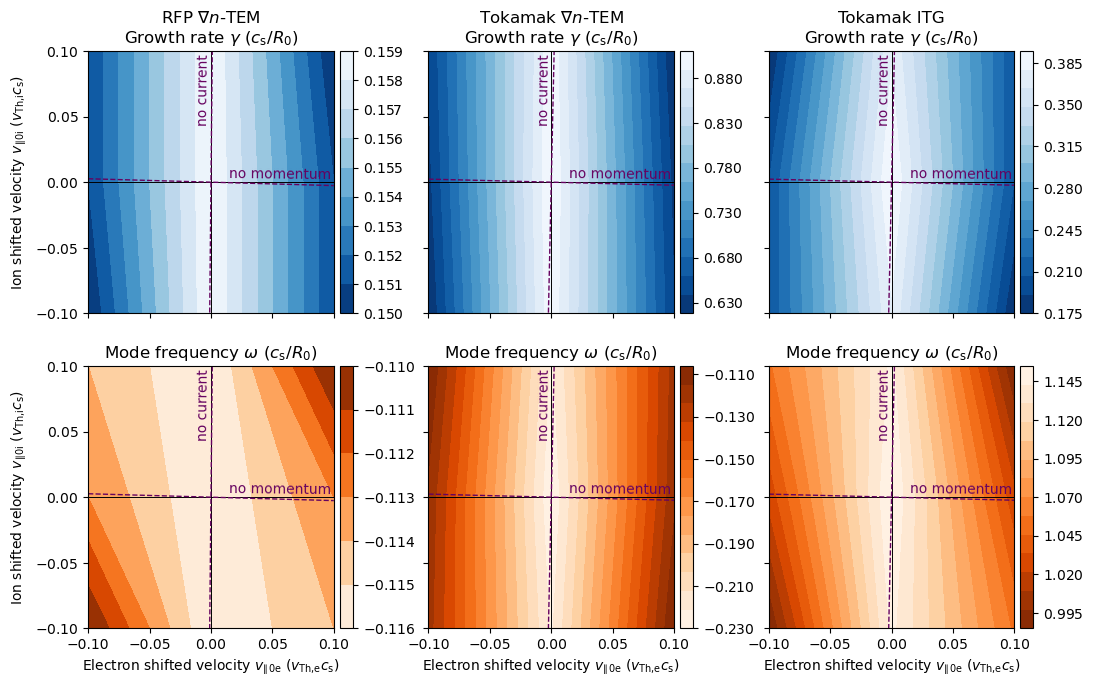

In [ ]:
# Get velocities and eigenvalues from data dictionary
V, O3 = eigenvalues['Tokamak_ITG_ky03000']
_, O2 = eigenvalues['Tokamak_nTEM_ky03000']
_, O1 = eigenvalues['RFP_nTEM_ky01275']
Os = [O1,O2,O3]
# Get parameters for this simulation
pars = [parameters_RFP_nTEM,parameters_Tokamak_nTEM,parameters_Tokamak_ITG]
# Set levels and ticks for gamma and omega
lgs = [np.linspace(0.150,0.159,10),np.linspace(0.618,0.910,15),np.linspace(0.175,0.395,15)]
tgs = [np.arange(0.150,0.159,0.001),np.arange(0.630,0.910,0.050),np.arange(0.175,0.395,0.035)]
los = [np.linspace(-0.116,-0.110,7),np.linspace(-0.230,-0.106,15),np.linspace(0.985,1.155,15)]
tos = [np.arange(-0.116,-0.110,0.001),np.arange(-0.230,-0.106,0.02),np.arange(0.995,1.155,0.025)]

# Interpolate data for clean plot
N = 3
Vi, Ve = np.mgrid[V[:,0].min():V[:,0].max():N*1j,V[:,1].min():V[:,1].max():N*1j]

# Create figure
fig, ax = plt.subplots(2,3,figsize=(12.6,7.5),sharey='row',sharex='col',gridspec_kw={'wspace':0.15})

for i, (O,lg,tg,lo,to,par) in enumerate(zip(Os,lgs,tgs,los,tos,pars)):
    gamma = griddata(V, O[:,0], (Vi, Ve), method='linear')
    omega = griddata(V, O[:,1], (Vi, Ve), method='linear')

    cf = ax[0,i].contourf(Ve,Vi,gamma,cmap='Blues_r',levels=lg)
    cbar = fig.colorbar(cf,pad=0.02)
    cbar.ax.set_yticks(tg, [f"${t:.3f}$" for t in tg]) 

    cf = ax[1,i].contourf(Ve,Vi,omega,levels=lo,cmap='Oranges_r' if i==2 else 'Oranges')
    ax[1,i].set_title(r'Mode frequency $\omega$ ($c_\text{s}/R_0$)')
    cbar = fig.colorbar(cf,pad=0.02)
    cbar.ax.set_yticks(to, [f"${t:.3f}$" for t in to]) 

    for axi in ax[:,i]:
        axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
        axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
        
        c_an = '#660260'
        axi.plot([-0.1,0.1],[-0.1*par.vThe/par.vThi,0.1*par.vThe/par.vThi],c=c_an,lw=1,ls='--')
        axi.annotate("no current",[0,0.098],c=c_an,rotation=89.4,va='top',ha='right')
        axi.plot([-0.1,0.1],[0.1*par.vThe/par.vThi*par.me/par.mi,-0.1*par.vThe/par.vThi*par.me/par.mi],c=c_an,lw=1,ls='--')
        axi.annotate("no momentum",[0.098,0],c=c_an,rotation=-0.6,va='bottom',ha='right')

for axi in ax[1,:]:
    axi.set_xlabel(r"Electron shifted velocity $v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{s}$)")
    axi.set_xlim(Ve.min(),Ve.max())

ticks = np.linspace(-0.1,0.1,5)
for axi in ax[:,0]:
    axi.set_ylim(Vi.min(),Vi.max())
    axi.set_yticks(ticks,[f"${t:.2f}$" for t in ticks])
    axi.set_ylabel(r"Ion shifted velocity $v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}c_\text{s}$)")

ax[0,0].set_title(r"RFP $\nabla n$-TEM"+"\n"+r"Growth rate $\gamma$ ($c_\text{s}/R_0$)",y=1)
ax[0,1].set_title(r"Tokamak $\nabla n$-TEM"+"\n"+r"Growth rate $\gamma$ ($c_\text{s}/R_0$)",y=1)
ax[0,2].set_title(r"Tokamak ITG"+"\n"+r"Growth rate $\gamma$ ($c_\text{s}/R_0$)",y=1)

plt.savefig("eigenvalues_dFdvp-off.pdf",bbox_inches='tight')

plt.show()

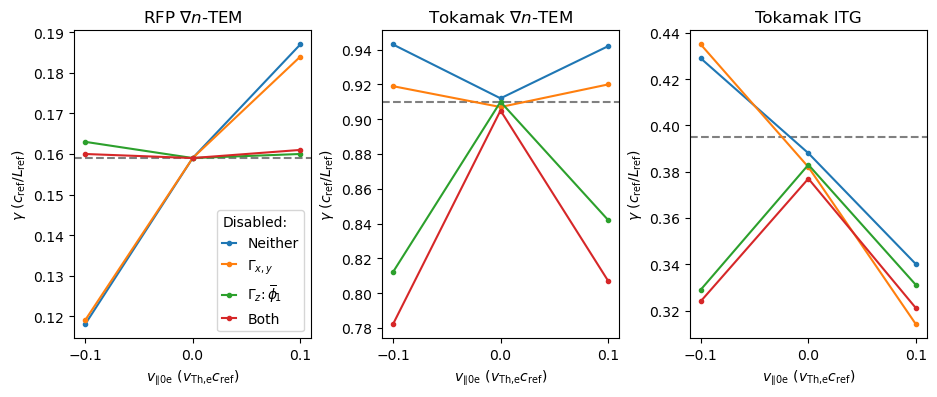

In [ ]:
## Growth rates at vpar0i=-0.1 and varying vpar0e, with different contributions 
## disabled 
fig, ax = plt.subplots(1,3,figsize=(11,4),gridspec_kw=dict(wspace=0.30))
v = [-0.1,0,0.1]

ax[0].set_title(r"RFP $\nabla n$-TEM")
ax[0].plot(v,[0.118,0.159,0.187],marker='.',label='Neither') # none
ax[0].plot(v,[0.119,0.159,0.184],marker='.',label=r'$\Gamma_{x,y}$') # curv
ax[0].plot(v,[0.163,0.159,0.160],marker='.',label=r'$\Gamma_{z}$: $\overline{\!\phi\!}_1$') # pdym
ax[0].plot(v,[0.160,0.159,0.161],marker='.',label='Both') # pdym+curv
ax[0].axhline(0.159,ls='--',c='grey',zorder=-1)
ax[0].legend(title='Disabled:',handlelength=1,alignment='left',loc='lower right')

ax[1].set_title(r"Tokamak $\nabla n$-TEM")
ax[1].plot(v,[0.943,0.912,0.942],marker='.') # none
ax[1].plot(v,[0.919,0.907,0.920],marker='.') # curv
ax[1].plot(v,[0.812,0.910,0.842],marker='.') # pdym
ax[1].plot(v,[0.782,0.905,0.807],marker='.') # pdym+curv
ax[1].axhline(0.910,ls='--',c='grey',zorder=-1)

ax[2].set_title(r"Tokamak ITG")
ax[2].plot(v,[0.429,0.388,0.340],marker='.') # none
ax[2].plot(v,[0.435,0.382,0.314],marker='.') # curv 
ax[2].plot(v,[0.329,0.383,0.331],marker='.') # pdym
ax[2].plot(v,[0.324,0.377,0.321],marker='.') # pdym+curv
ax[2].axhline(0.395,ls='--',c='grey',zorder=-1)

for axi in ax:
    axi.set_xlabel(r"$v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{ref}$)") # given vp0i=-0.1
    axi.set_xticks(v)
    axi.set_ylabel(r"$\gamma$ ($c_\text{ref}/L_\text{ref}$)")

plt.savefig(fr"dFdvp-off_line.pdf",bbox_inches='tight')

plt.show()

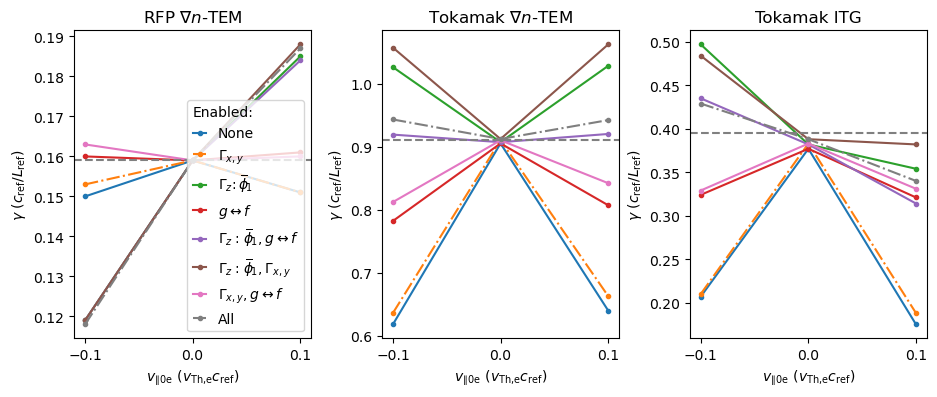

In [26]:
# Same as above, but enabling all tested terms one-by-one
fig, ax = plt.subplots(1,3,figsize=(11,4),gridspec_kw=dict(wspace=0.30))
v = [-0.1,0,0.1]

ax[0].set_title(r"RFP $\nabla n$-TEM")
ax[0].plot(v,[0.150,0.159,0.151],marker='.',label='None') # all
ax[0].plot(v,[0.153,0.159,0.151],marker='.',ls='-.',label=r'$\Gamma_{x,y}$') # pdym+g
ax[0].plot(v,[0.119,0.159,0.185],marker='.',label=r'$\Gamma_{z}$: $\overline{\!\phi\!}_1$') # curv+g
ax[0].plot(v,[0.160,0.159,0.161],marker='.',label=r'$g\leftrightarrow f$') # pdym+curv
ax[0].plot(v,[0.119,0.159,0.184],marker='.',label=r'$\Gamma_{z}:\ \overline{\!\phi\!}_1, g\leftrightarrow f$') # curv
ax[0].plot(v,[0.119,0.159,0.188],marker='.',label=r'$\Gamma_{z}:\ \overline{\!\phi\!}_1,\Gamma_{x,y}$') # g
ax[0].plot(v,[0.163,0.159,0.160],marker='.',label=r'$\Gamma_{x,y}, g\leftrightarrow f$') # pdym
ax[0].plot(v,[0.118,0.159,0.187],marker='.',ls='-.',label='All') # none
ax[0].axhline(0.159,ls='--',c='grey')
ax[0].legend(title='Enabled:',handlelength=1,alignment='left',loc='lower right')

ax[1].set_title(r"Tokamak $\nabla n$-TEM")
ax[1].plot(v,[0.618,0.905,0.640],marker='.') # all
ax[1].plot(v,[0.636,0.910,0.663],marker='.',ls='-.') # pdym+g
ax[1].plot(v,[1.026,0.907,1.028],marker='.') # curv+g
ax[1].plot(v,[0.782,0.905,0.807],marker='.') # pdym+curv
ax[1].plot(v,[0.919,0.907,0.920],marker='.') # curv
ax[1].plot(v,[1.057,0.912,1.062],marker='.') # g
ax[1].plot(v,[0.812,0.910,0.842],marker='.') # pdym
ax[1].plot(v,[0.943,0.912,0.942],marker='.',ls='-.') # none
ax[1].axhline(0.910,ls='--',c='grey')

ax[2].set_title(r"Tokamak ITG")
ax[2].plot(v,[0.207,0.377,0.175],marker='.') # all
ax[2].plot(v,[0.210,0.383,0.188],marker='.',ls='-.') # pdym+g 
ax[2].plot(v,[0.497,0.382,0.354],marker='.') # curv+g 
ax[2].plot(v,[0.324,0.377,0.321],marker='.') # pdym+curv
ax[2].plot(v,[0.435,0.382,0.314],marker='.') # curv 
ax[2].plot(v,[0.484,0.388,0.382],marker='.') # g
ax[2].plot(v,[0.329,0.383,0.331],marker='.') # pdym
ax[2].plot(v,[0.429,0.388,0.340],marker='.',ls='-.') # none
ax[2].axhline(0.395,ls='--',c='grey')

for axi in ax:
    axi.set_xlabel(r"$v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{ref}$)") # given vp0i=-0.1
    axi.set_xticks(v)
    axi.set_ylabel(r"$\gamma$ ($c_\text{ref}/L_\text{ref}$)")

plt.show()

## Velocity-space structure of the eigenvector

In [15]:
## Load velocity-space data for the 3 investigated scenarios
vspace_dict = {}
labels = ["vpar","mu","tpb"]
labels.extend(["dist_v"]*32) # if multiple time steps in data, keep overwriting until only last time step (converged) is stored
for mode in ["RFPTEM","TokTEM","TokITG"]:
    vspace_dict[mode] = {"dist":{},"tpb":{},"mu":[],"vpar":[]}

    for s in ["e","i"]:
        for i in ["000","001","005","010","020","040"]:
            try:
                dat = genfromASCII(fr"vspace/vsp1{s}_{mode}_vim010vep{i}.dat",labels)
                vpar = dat['vpar']
                mu   = dat['mu']
                vspace_dict[mode]['tpb'][f"{s}_vim010vep{i}"] = np.array([dat['tpb'][1::2], dat['tpb'][::2]])
                vspace_dict[mode]['dist'][f"{s}_vim010vep{i}"] = dat['dist_v'].reshape((len(vpar),len(mu)))
            except: continue

        for i in ["001","005","020"]:
            dat = genfromASCII(fr"vspace/vsp1{s}_{mode}_vip010vem{i}.dat",labels)
            vspace_dict[mode]['vpar'] = dat['vpar']
            vspace_dict[mode]['mu'] = dat['mu']
            vspace_dict[mode]['tpb'][f"{s}_vip010vem{i}"] = np.array([dat['tpb'][1::2], dat['tpb'][::2]])
            vspace_dict[mode]['dist'][f"{s}_vip010vem{i}"] = dat['dist_v'].reshape((len(dat['vpar']),len(dat['mu'])))

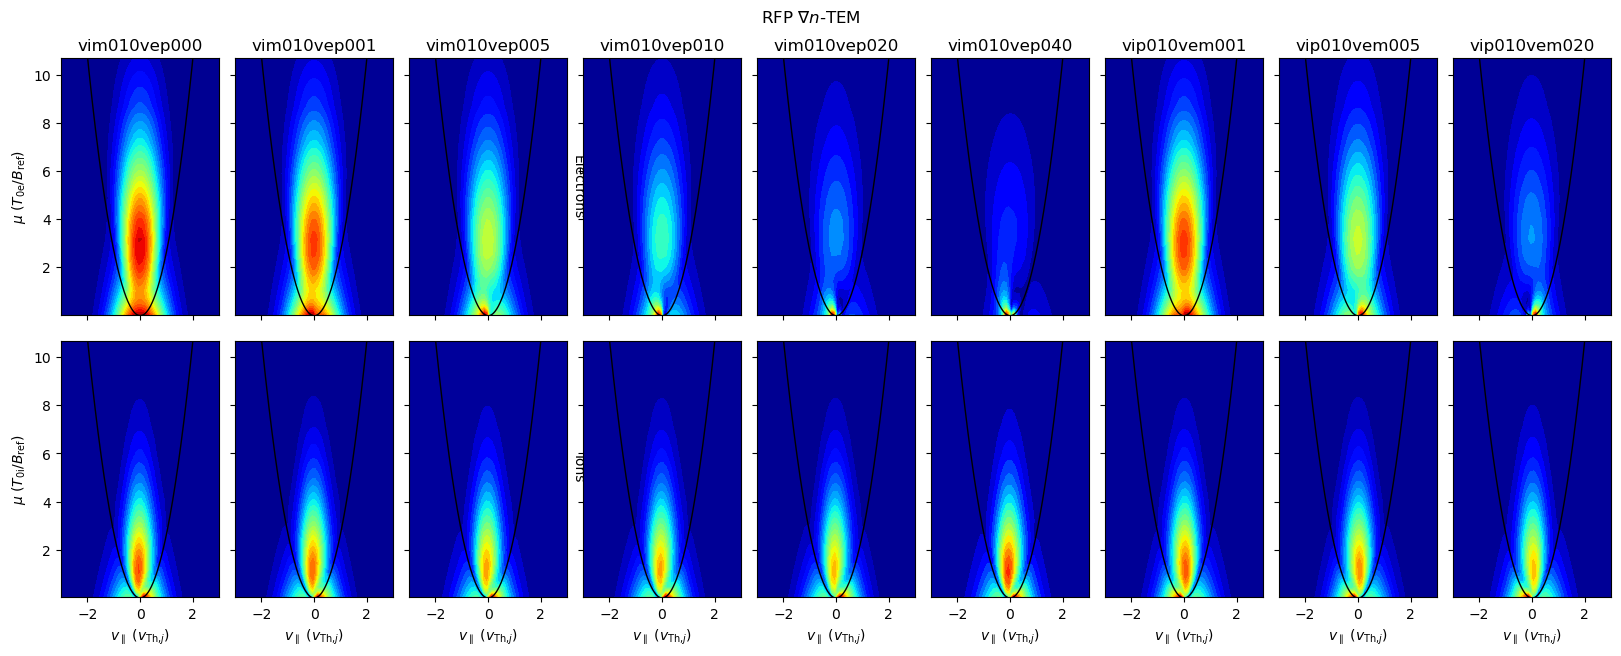

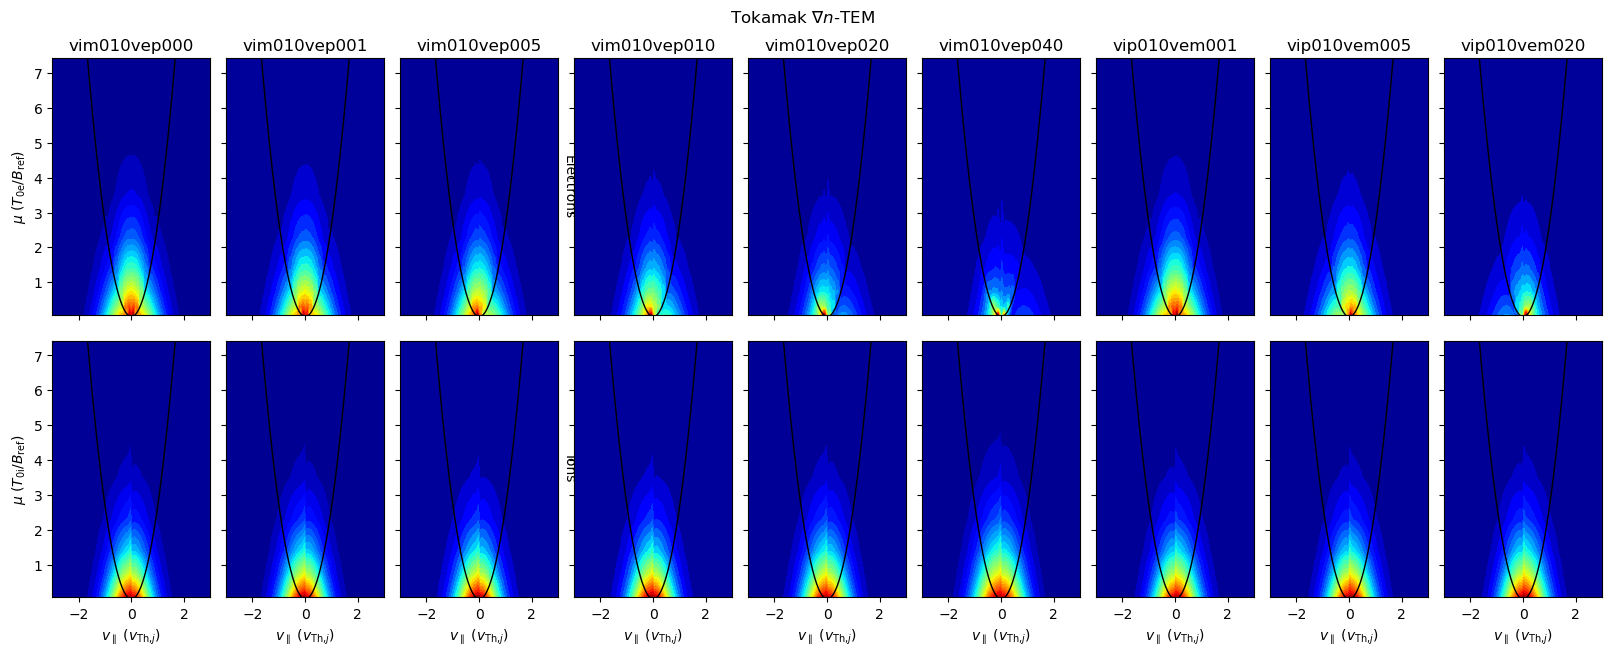

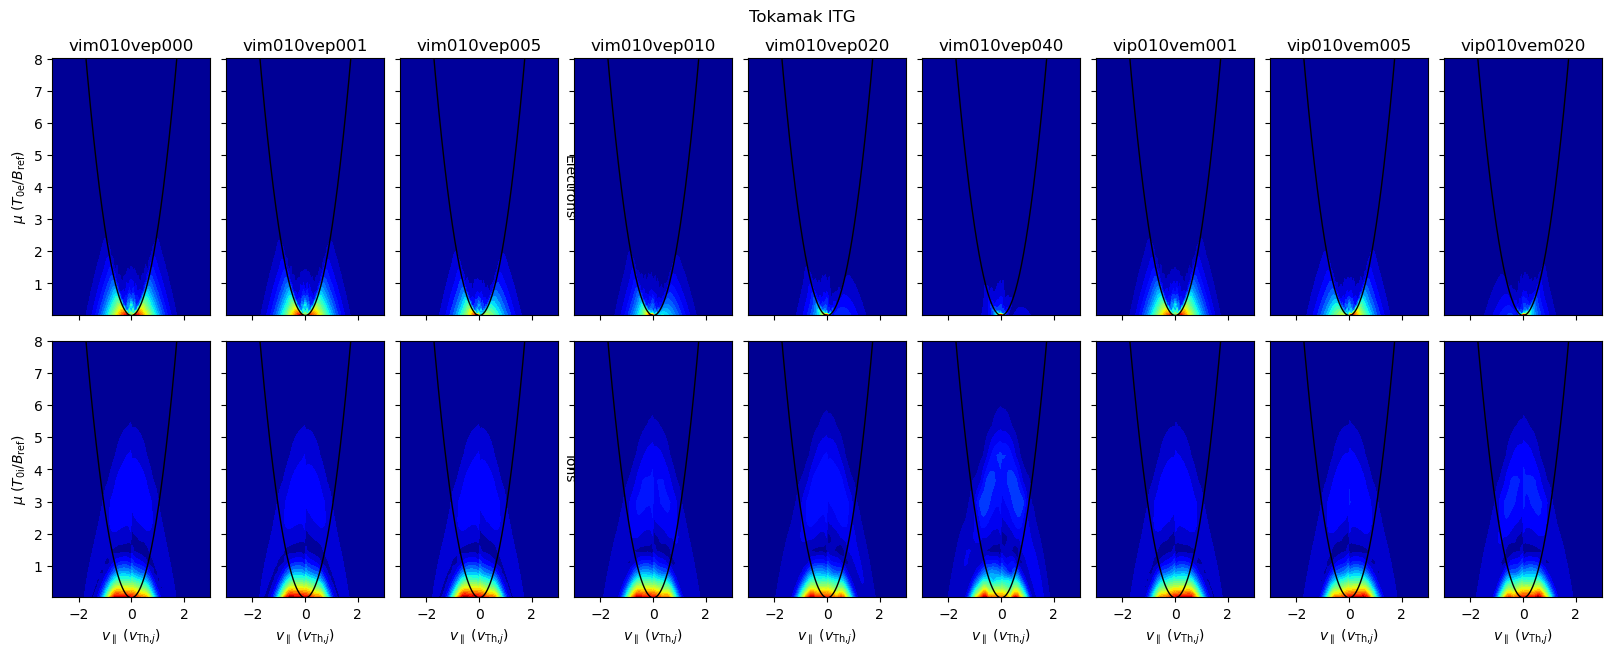

In [16]:
## Plot all velocity space data
for m, mode in enumerate(["RFPTEM","TokTEM","TokITG"]):
    dist = vspace_dict[mode]['dist']
    tpb = vspace_dict[mode]['tpb']
    vpar = vspace_dict[mode]['vpar']
    mu = vspace_dict[mode]['mu']
    keys = np.array(list(dist.keys())).reshape((2,len(dist.keys())//2))
    
    fig, ax = plt.subplots(2,len(dist.keys())//2,figsize=(20,7),sharey=True,
                           sharex=True,gridspec_kw={'wspace':0.1,'hspace':0.1})

    for i in range(2):
        for j, key in enumerate(keys[i]):
            cf = ax[i,j].contourf(vpar,mu,dist[key].T,levels=25,cmap='jet')
            xtpb = np.linspace(-3,3,1000)
            Ptpb = Polynomial.fit(*tpb[key],2)(xtpb)
            ax[i,j].plot(xtpb,Ptpb,c='black',lw=1)
            if i == 1:
                ax[1,j].set_xlabel(r"$v_{\parallel}$ ($v_{\text{Th,}j}$)")
            else:
                ax[0,j].set_title(key[2:])

    ax[0,0].set_ylabel(r"$\mu$ ($T_{0\text{e}}/B_\text{ref}$)")
    ax[1,0].set_ylabel(r"$\mu$ ($T_{0\text{i}}/B_\text{ref}$)")
    ax[0,0].set_ylim(mu.min(),mu.max())
    ax[0,2].text(1.02,0.5,"Electrons",transform=ax[0,2].transAxes,rotation=-90,va='center',ha='left')
    ax[1,2].text(1.02,0.5,"Ions",transform=ax[1,2].transAxes,rotation=-90,va='center',ha='left')

    fig.suptitle([r"RFP $\nabla n$-TEM",r"Tokamak $\nabla n$-TEM",r"Tokamak ITG"][m],y=0.95)

    plt.show()

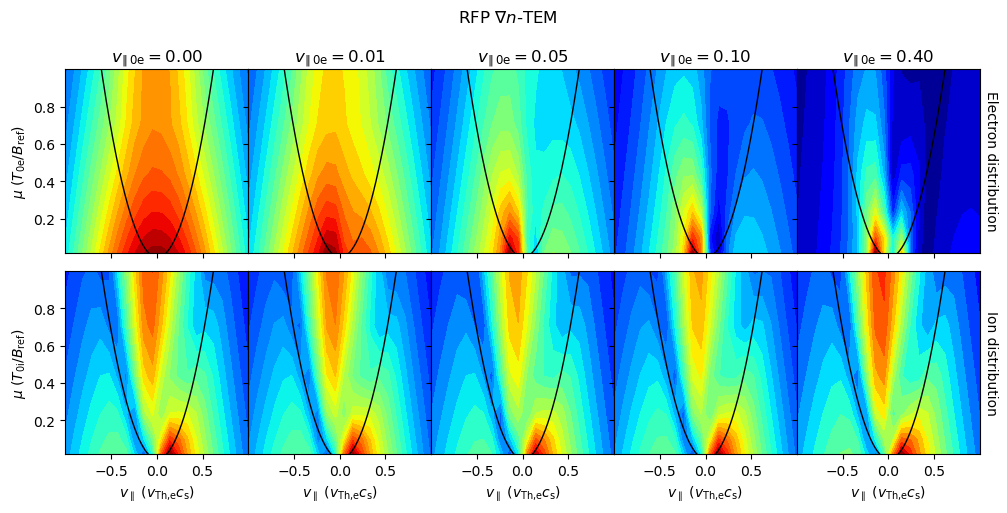

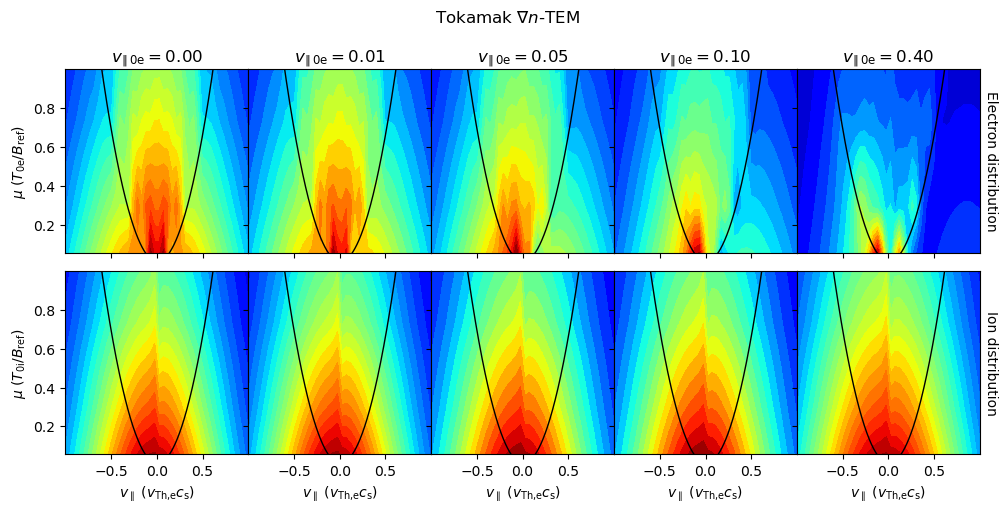

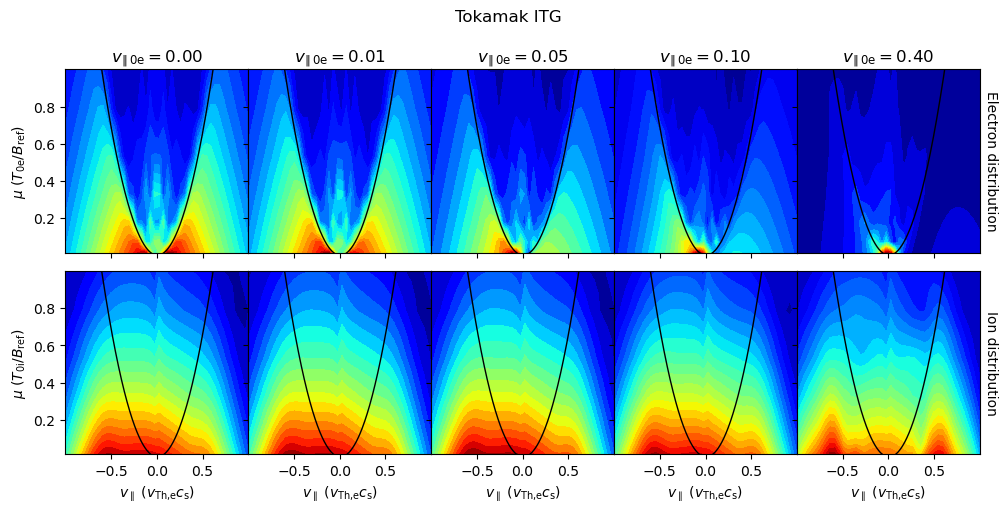

In [17]:
## Velocity space plots for increasing vpar0e
for m, mode in enumerate(["RFPTEM","TokTEM","TokITG"]):
    dist = vspace_dict[mode]['dist']
    tpb = vspace_dict[mode]['tpb']
    vpar = vspace_dict[mode]['vpar']
    mu = vspace_dict[mode]['mu']
    keys = np.array(list(dist.keys())).reshape((2,len(dist.keys())//2))
    
    fig, ax = plt.subplots(2,5,figsize=(11.8,5),sharey='row',sharex='col',
                           gridspec_kw={'wspace':0.,'hspace':0.1})

    for i in range(2):
        ax[i,0].set_ylim(mu.min(),1)
        ax[i,0].set_yticks([0.2,0.4,0.6,0.8])
        ax[i,-1].text(1.02,0.5,["Electron distribution","Ion distribution"][i],transform=ax[i,-1].transAxes,rotation=-90,va='center',ha='left')

        
        for j, key in enumerate(keys[i][[0,1,2,3,5]]):
            cf = ax[i,j].contourf(vpar,mu,dist[key].T,levels=25,cmap='jet')
            xtpb = np.linspace(-1,1,1000)
            Ptpb = Polynomial.fit(*tpb[key],2)(xtpb)
            ax[i,j].plot(xtpb,Ptpb,c='black',lw=1)


            if i == 0: ax[0,j].set_title(r'$v_{\!\parallel0\text{e}}=0.\!$'+fr'${key[-2:]}$')
            if i == 1: 
                ax[1,j].set_xlim(-1,1)
                ax[1,j].set_xticks([-0.5,0,0.5])
                ax[1,j].set_xlabel(r"$v_{\parallel}$ ($v_\text{Th,e}c_\text{s}$)")
                
    ax[0,0].set_ylabel(r"$\mu$ ($T_{0\text{e}}/B_\text{ref}$)")
    ax[1,0].set_ylabel(r"$\mu$ ($T_{0\text{i}}/B_\text{ref}$)")            
    ax[0,2].text(1.02,0.5,"Electrons",transform=ax[0,2].transAxes,rotation=-90,va='center',ha='left')
    ax[1,2].text(1.02,0.5,"Ions",transform=ax[1,2].transAxes,rotation=-90,va='center',ha='left')

    fig.suptitle([r"RFP $\nabla n$-TEM",r"Tokamak $\nabla n$-TEM",r"Tokamak ITG"][m],y=1)

    plt.savefig(fr"vspace_{mode}.pdf",bbox_inches='tight')
    plt.show()

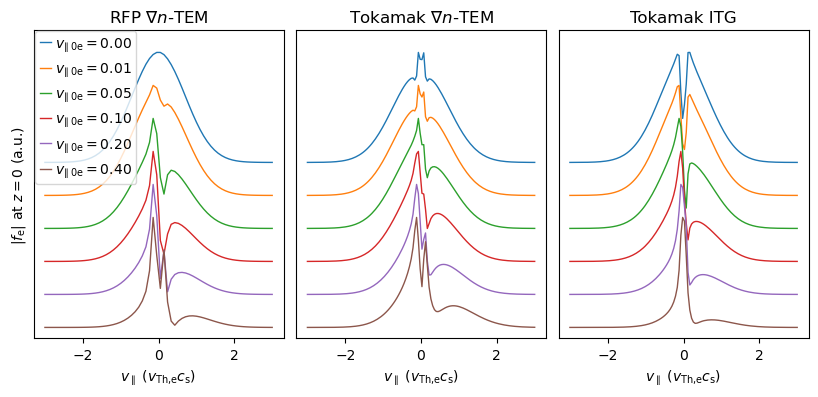

In [18]:
## mu=0 slice of above velocity space distributions
fig, ax = plt.subplots(1,3,figsize=(10,4),sharey=True, gridspec_kw={'wspace':0.05})
ax[0].set_ylabel(r"$|f_\text{e}|$ at $z=0$ (a.u.)")
ax[0].set_yticks([])

for m, mode in enumerate(["RFPTEM","TokTEM","TokITG"]):
    dist = vspace_dict[mode]['dist']
    tpb = vspace_dict[mode]['tpb']
    vpar = vspace_dict[mode]['vpar']
    mu = vspace_dict[mode]['mu']
    keys = np.array(list(dist.keys())).reshape((2,len(dist.keys())//2))

    ax[m].set_xlabel(r"$v_{\parallel}$ ($v_\text{Th,e}c_\text{s}$)")
    ax[m].set_title([r"RFP $\nabla n$-TEM",r"Tokamak $\nabla n$-TEM",r"Tokamak ITG"][m],y=1)

    for j, key in enumerate(keys[0][:-3]):
        f = [1,0.9,0.8,0.6,0.4,0.2][j]
        ax[m].plot(vpar,dist[key][:,0]/dist[key][:,0].max()-0.3*j,label=r'$v_{\!\parallel0\text{e}}=0.\!$'+fr'${key[-2:]}$',lw=1)

ax[0].legend(handlelength=0.8,borderpad=0.3,bbox_to_anchor=(-0.02,1.02),handletextpad=0.3,loc='upper left')
ax[0].set_ylim(-1.6,1.2)

plt.show()

## Reduced analytical ITG-model

In [ ]:
def Z(x):
    """Plasma dispersion function."""
    return 1j*np.sqrt(np.pi)*np.exp(-x**2)*(1+erf(1j*x))

def dispersion(zi,vpar0i,vpar0e,T0i,T0e,vThi,omn,omTi,B0,J,Kx,Ky,kx,ky,kz,gradvpar0i,gradvpar0e):
    """Matches Hammett (2007) notes, but includes velocity shift and gradient."""
    omdhati = T0i/B0*(Kx*kx+Ky*ky)

    p2 = T0i/T0e * (1 - vpar0e*Z(-vpar0e))
    p1 = -(T0i*ky*omn + 2*omdhati)
    p0 = -2*T0i*ky*omdhati*(omn*(vpar0i**2+1)+omTi-vpar0i*gradvpar0i) 
    p0 -= omdhati**2*(8*vpar0i**2+7)

    if isinstance(zi,int):
        return p2, p1[zi], p0[zi]
    else:
        return p2, np.mean(p1), np.mean(p0)
    
def dispersion(zi,vpar0i,vpar0e,T0i,T0e,vThi,vThe,omn,omTi,B0,J,Kx,Ky,kx,ky,kz,gradvpar0i,gradvpar0e):
    """Hammett (2007) but with ion parallel dynamics, including velocity shift and gradient."""
    omdhati = T0i/B0*(Kx*kx+Ky*ky)

    p2 = T0i/T0e * (1 - vpar0e*Z(-vpar0e))
    p1 = -(T0i*ky*omn + 2*omdhati)
    p0 = -2*T0i*ky*omdhati*(omn*(vpar0i**2+1)+omTi-vpar0i*gradvpar0i) 
    p0 -= omdhati**2*(8*vpar0i**2+7) + 5*omdhati*kz/(J*B0)*vThi*vpar0i
    p0 -= kz/(J*B0)*vThi*T0i*ky*(omn*vpar0i-gradvpar0i) + (kz/(J*B0)*vThi)**2/2

    if isinstance(zi,int):
        return p2, p1[zi], p0[zi]
    else:
        return p2, np.mean(p1), np.mean(p0)
    
P = parameters_Tokamak_ITG
disp = lambda zi, kz, vpar0i, vpar0e, gradvpar0i, gradvpar0e: dispersion(zi,vpar0i,vpar0e,P.T0i,P.T0e,P.vThi,P.vThe,P.omn,P.omti,P.B0,P.J,P.Kx,P.Ky,P.kx,P.ky,kz,gradvpar0i,gradvpar0e)
kz = 0.9
zi = None

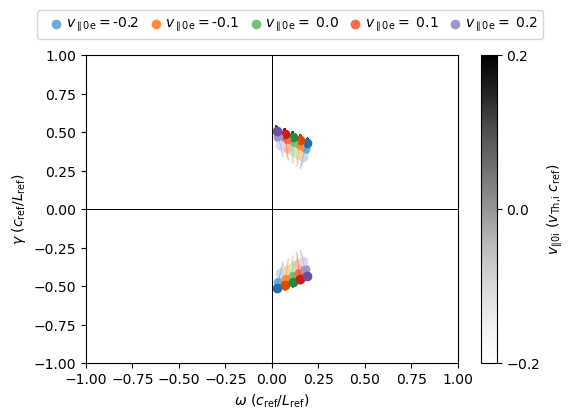

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
vi = np.linspace(-0.2,0.2,500)
ve = np.linspace(-0.2,0.2,5)

for j, vpar0e in enumerate(ve):
    roots = np.empty((len(vi),2),dtype=complex)
    if j == 0: cmap = 'Blues'
    elif j == 1: cmap = 'Oranges'
    elif j == 2: cmap = 'Greens'
    elif j == 3: cmap = 'Reds'
    elif j == 4: cmap = 'Purples'

    for i, vpar0i in enumerate(vi):
        # Solve analytical dispersion relation for eigenvalues
        rootsi = np.roots(disp(zi,kz,vpar0i,vpar0e,0,0))

        # Sort roots to get continous trajectories without mutual jumps
        if i>=1:
            cost = np.abs(roots[i-1][:,np.newaxis]-rootsi[np.newaxis,:])
            _, indeces = lsa(cost)
            roots[i] = rootsi[indeces]
        else:
            roots[i] = rootsi

    # Solve analytical dispersion relation at some specific velocities
    root0 = np.roots(disp(zi,kz,0,vpar0e,0,0))
    root01 = np.roots(disp(zi,kz,0.1,vpar0e,0,0))
    root_01 = np.roots(disp(zi,kz,-0.1,vpar0e,0,0))

    # Plot roots as root-locus plot (root trajectories of parameter vpar0i, for 
    # various vpar0e)
    for axi in [ax]:
        axi.plot(roots[:,0].real,roots[:,0].imag,c=f'C{j}',lw=0.2)
        axi.plot(roots[:,1].real,roots[:,1].imag,c=f'C{j}',lw=0.2)
        axi.scatter(roots[:,0].real,roots[:,0].imag,marker='.',s=1,c=vi,
                    cmap=cmap)
        axi.scatter(roots[:,1].real,roots[:,1].imag,marker='.',s=1,c=vi,
                    cmap=cmap)
        axi.scatter(root0.real,root0.imag,color=plt.get_cmap(cmap)(0.5),
                    label=r'$v_{\parallel0\text{e}}=$'+f"{vpar0e: 1.1f}")
        axi.scatter(root01.real,root01.imag,color=plt.get_cmap(cmap)(0.75))
        axi.scatter(root_01.real,root_01.imag,color=plt.get_cmap(cmap)(0.25))

        axi.axhline(0,c='black',lw=0.7)
        axi.axvline(0,c='black',lw=0.7)
        axi.set_xlabel(r"$\omega$ ($c_\text{ref}/L_\text{ref}$)")
        axi.set_ylabel(r"$\gamma$ ($c_\text{ref}/L_\text{ref}$)")


cb = plt.colorbar(plt.cm.ScalarMappable(cmap='Greys'), ax=ax)
cb.ax.set_yticks([0,0.5,1],[f"${vi.min(): 1.1f}$",f"${0: 1.1f}$",f"${vi.max(): 1.1f}$"])
cb.set_label(r"$v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}\ c_\text{ref}$)")

ax.legend(loc='center left',ncol=5,bbox_to_anchor=(-0.15,1.1),columnspacing=0.15,handletextpad=-0.3)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

plt.savefig('ITG_roots_disp.svg',bbox_inches='tight')

plt.show()

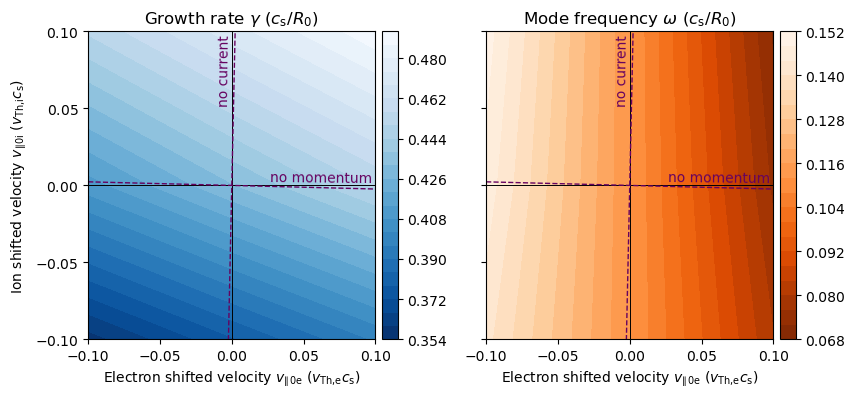

In [ ]:
N = 3
Vi, Ve = np.mgrid[-0.1:0.1:N*1j,-0.1:0.1:N*1j]
roots = np.empty([*Vi.shape,2],dtype=complex)
for i in range(N):
    for e in range(N):
        # Solve analytical dispersion relation for eigenvalues
        roots_ie = np.roots(disp(zi,kz,Vi[i,e],Ve[i,e],0,0))

        # Sort roots to get continous trajectories without mutual jumps
        if e>=1:
            cost = np.abs(roots[i,e-1][:,np.newaxis]-roots_ie[np.newaxis,:])**2
            _, indeces = lsa(cost)
            roots[i,e] = roots_ie[indeces]
        elif e==0 and i>=1:
            cost = np.abs(roots[i-1,e][:,np.newaxis]-roots_ie[np.newaxis,:])**2
            _, indeces = lsa(cost)
            roots[i,e] = roots_ie[indeces]
        else:
            roots[i,e] = roots_ie
        
# Get eigenvalues from roots, manually selecting which of the two
Ri = [0,1]
R = roots[:,:,0]*Ri[0] + roots[:,:,1]*Ri[1]
gamma, omega = R.imag[:,:], R.real[:,:]

# Create figure
fig, ax = plt.subplots(1,2,figsize=(9.6,4),sharey=True,gridspec_kw={'wspace':0.15})

# Plot solutions of analytical dispersion relation as function of parallel 
# velocities
cf = ax[0].contourf(Ve,Vi,gamma,cmap='Blues_r',levels=25)
ax[0].set_title(r'Growth rate $\gamma$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)

cf = ax[1].contourf(Ve,Vi,omega,levels=25,cmap='Oranges_r')
ax[1].set_title(r'Mode frequency $\omega$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)

for axi in ax:
    axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
    axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
    axi.set_xlabel(r"Electron shifted velocity $v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{s}$)")
    axi.set_xlim(Ve.min(),Ve.max())

    c_an = '#660260'
    axi.plot([-0.1,0.1],[-0.1*P.vThe/P.vThi,0.1*P.vThe/P.vThi],c=c_an,lw=1,ls='--')
    axi.annotate("no current",[0,0.098],c=c_an,rotation=89.4,va='top',ha='right')
    axi.plot([-0.1,0.1],[0.1*P.vThe/P.vThi*P.me/P.mi,-0.1*P.vThe/P.vThi*P.me/P.mi],c=c_an,lw=1,ls='--')
    axi.annotate("no momentum",[0.098,0],c=c_an,rotation=-0.6,va='bottom',ha='right')

ax[0].set_ylim(Vi.min(),Vi.max())
ticks = np.linspace(-0.1,0.1,5)
ax[0].set_yticks(ticks,[f"${t:.2f}$" for t in ticks])
ax[0].set_ylabel(r"Ion shifted velocity $v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}c_\text{s}$)")

plt.savefig('eigenvalues_tokamak_ITG_disp.pdf',bbox_inches='tight')

plt.show()

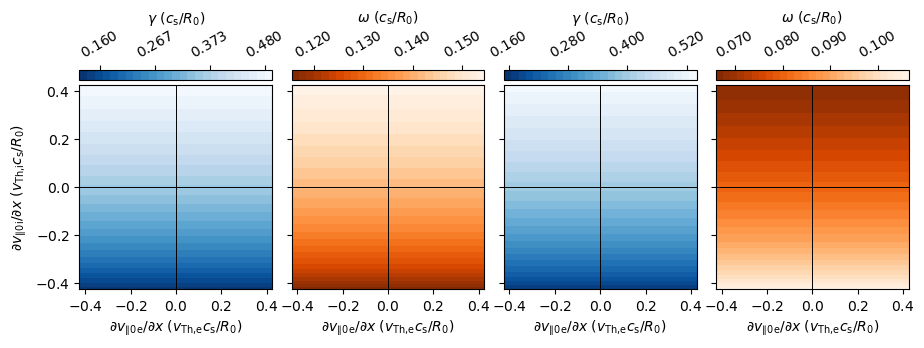

In [ ]:
N = 101
gVi, gVe = np.mgrid[-0.425:0.425:N*1j,-0.425:0.425:N*1j]
roots1 = np.empty([*gVi.shape,2],dtype=complex)
roots2 = np.empty([*gVi.shape,2],dtype=complex)
for i in range(N):
    for e in range(N):
        # Solve analytical dispersion relation
        roots1_ie = np.roots(disp(zi,kz,-0.1,-0.1,gVi[i,e],gVe[i,e]))
        roots2_ie = np.roots(disp(zi,kz,-0.1,0.1,gVi[i,e],gVe[i,e]))

        # Sort roots to get continous trajectories without mutual jumps
        if e>=1:
            cost1 = np.abs(roots1[i,e-1][:,np.newaxis]-roots1_ie[np.newaxis,:])
            cost2 = np.abs(roots2[i,e-1][:,np.newaxis]-roots2_ie[np.newaxis,:])
            _, indeces1 = lsa(cost1)
            _, indeces2 = lsa(cost2)
            roots1[i,e] = roots1_ie[indeces1]
            roots2[i,e] = roots2_ie[indeces2]
        elif e==0 and i>=1:
            cost1 = np.abs(roots1[i-1,e][:,np.newaxis]-roots1_ie[np.newaxis,:])
            cost2 = np.abs(roots2[i-1,e][:,np.newaxis]-roots2_ie[np.newaxis,:])
            _, indeces1 = lsa(cost1)
            _, indeces2 = lsa(cost2)
            roots1[i,e] = roots1_ie[indeces1]
            roots2[i,e] = roots2_ie[indeces2]
        else:
            roots1[i,e] = roots1_ie
            roots2[i,e] = roots2_ie
        
# Get eigenvalues from roots, automatically selecting those with positive growth
R1 = roots1[:,:,0] if (roots1[:,:,0].imag>0).all() else roots1[:,:,1]
R2 = roots2[:,:,0] if (roots2[:,:,0].imag>0).all() else roots2[:,:,1]
gamma1, omega1 = R1.imag[:,:], R1.real[:,:]
gamma2, omega2 = R2.imag[:,:], R2.real[:,:]

fig, ax = plt.subplots(1,4,figsize=(10.7,3.2),sharey=True,gridspec_kw={'wspace':0.1})

# Plot eigenvalues as function of parallel velocity gradients for 
# vpar0i=vpar0e=0.1
cf = ax[0].contourf(gVe,gVi,gamma1,cmap='Blues_r',levels=25)
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\gamma$ ($c_\text{s}/R_0$)')
tg1 = np.linspace(0.160,0.480,4)
cbar.ax.set_xticks(tg1, [f"${t:.3f}$" for t in tg1], rotation=30) 

cf = ax[1].contourf(gVe,gVi,omega1,levels=25,cmap='Oranges_r')
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\omega$ ($c_\text{s}/R_0$)')
to1 = np.linspace(0.12,0.15,4)
cbar.ax.set_xticks(to1, [f"${t:.3f}$" for t in to1], rotation=30) 

# Plot eigenvalues as function of parallel velocity gradients for 
# vpar0i=-vpar0e=0.1
cf = ax[2].contourf(gVe,gVi,gamma2,cmap='Blues_r',levels=25)
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\gamma$ ($c_\text{s}/R_0$)')
tg2 = np.linspace(0.16,0.52,4)
cbar.ax.set_xticks(tg2, [f"${t:.3f}$" for t in tg2], rotation=30)  

cf = ax[3].contourf(gVe,gVi,omega2,levels=25,cmap='Oranges_r')
cbar = fig.colorbar(cf,orientation='horizontal',location='top',pad=0.02,label=r'$\omega$ ($c_\text{s}/R_0$)')
to2 = np.linspace(0.07,0.1,4)
cbar.ax.set_xticks(to2, [f"${t:.3f}$" for t in to2], rotation=30) 

ticks = np.linspace(-0.4,0.4,5)
for axi in ax:
    axi.plot([0,0],[gVi.min(),gVi.max()],c='black',lw=0.7)
    axi.plot([gVe.min(),gVe.max()],[0,0],c='black',lw=0.7)
    axi.set_xlabel(r"$\partial v_{\!\parallel\!0\text{e}}/\partial x$ ($v_\text{Th,e}c_\text{s}/R_0$)")
    axi.set_xlim(gVe.min(),gVe.max())
    axi.set_xticks(ticks,[f"${t:.1f}$" for t in ticks])

ax[0].set_ylim(gVi.min(),gVi.max())
ax[0].set_yticks(ticks,[f"${t:.1f}$" for t in ticks])
ax[0].set_ylabel(r"$\partial v_{\!\parallel\!0\text{i}}/\partial x$ ($v_\text{Th,i}c_\text{s}/R_0$)")

plt.savefig("eigenvalues_grad_tokamak_ITG_disp.pdf",bbox_inches='tight')

plt.show()

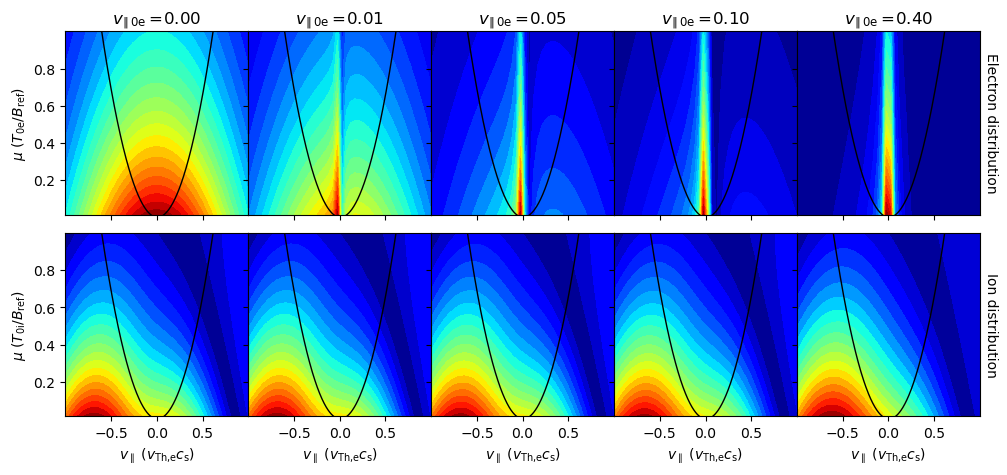

In [ ]:
def fe(zi,vpar,mu, vpar0e,B0):
    """Perturbed electron distribution (adiabatic electrons)."""
    if isinstance(zi,int): B0 = B0[zi]
    else: B0 = np.mean(B0)
    F0e = np.exp(-(vpar-vpar0e)**2-mu*B0)
    return (1-vpar0e/vpar)*F0e

def fi(zi,vpar,mu, vpar0i,gradvpar0i,omc,B0,kpar,vThi,T0i,omn,omTi,Kx,kx,Ky,ky,J):
    """Perturbed ion distribution (fast-wave approximation)."""
    if isinstance(zi,int): B0 = B0[zi]; J = J[zi]; Kx = Kx[zi]; Ky = Ky[zi]
    else: B0 = np.mean(B0); J = np.mean(J); Kx = np.mean(Kx); Ky = np.mean(Ky)
    omstar = T0i*ky*(omn+omTi*((vpar-vpar0i)**2+mu*B0-3/2)-2*(vpar-vpar0i)*gradvpar0i)
    omdhati = T0i/B0*(Kx*kx+Ky*ky)
    F0i = np.exp(-(vpar-vpar0i)**2-mu*B0)
    A = omstar + omdhati*(2*vpar*(vpar-vpar0i)+mu*B0) + kpar*vThi/(J*B0)*(vpar-vpar0i)
    B = 1/omc + (omdhati*(2*vpar**2+mu*B0) + kpar*vThi/(J*B0)*vpar)/omc**2
    return A*B*F0i
    
# Load velocity space data from GENE output, for trapped particle boundary
# and velocity ranges
labels = ["vpar","mu","tpb"]
labels.extend(["dist_v"]*32)
dist = {}; tpb = {}
for s in ["e","i"]:
    dat = genfromASCII(fr"vspace/vsp1{s}_TokITG_vim010vep010.dat",labels)
    vpar = dat['vpar']
    mu   = dat['mu']
    tpb[s] = np.array([dat['tpb'][1::2], dat['tpb'][::2]])

fig, ax = plt.subplots(2,5,figsize=(11.8,5),sharey='row',sharex='col',
                       gridspec_kw={'wspace':0.,'hspace':0.1})

m = np.linspace(mu.min(),mu.max(),128)
V, M = np.meshgrid(vpar,m)
xtpb = np.linspace(-1,1,1000)
Ptpbe = Polynomial.fit(*tpb["e"],2)(xtpb)
Ptpbi = Polynomial.fit(*tpb["i"],2)(xtpb)
m1, m2 = np.meshgrid(Polynomial.fit(*tpb["e"],2)(vpar),m)

# Uncomment below definition of `mask` to artificially deplete all trapped 
# electrons, for comparison with the numerical results
mask = 1
# mask = (m1 > m2-0.03)

for j, vpar0e in enumerate([0,0.01,0.05,0.1,0.4]):
    # Solve analytical dispersion relation for complex mode frequencies, as 
    # input for analytical distribution functions
    roots = np.roots(disp(zi,kz,-0.1,vpar0e,0,0))
    omc = roots[np.argmax(roots.imag)]
    
    # Plot electron and ion perturbed distribution functions
    ax[0,j].contourf(vpar,m,np.abs(fe(zi,V,M,vpar0e,P.B0))*mask,levels=25,cmap='jet')
    ax[1,j].contourf(vpar,m,np.abs(fi(zi,V,M,-0.1,0,omc,P.B0,kz,P.vThi,P.T0i,P.omn,P.omti,P.Kx,P.kx,P.Ky,P.ky,P.J)),levels=25,cmap='jet')
    ax[0,j].plot(xtpb,Ptpbe,c='black',lw=1)
    ax[1,j].plot(xtpb,Ptpbi,c='black',lw=1)

    ax[0,j].set_title(r'$v_{\!\parallel0\text{e}}=\!$'+fr'${vpar0e:1.2f}$')
    ax[1,j].set_xlim(-1,1)
    ax[1,j].set_xticks([-0.5,0,0.5])
    ax[1,j].set_xlabel(r"$v_{\parallel}$ ($v_\text{Th,e}c_\text{s}$)")
                
for i in range(2):
    ax[i,0].set_ylim(mu.min(),1)
    ax[i,0].set_yticks([0.2,0.4,0.6,0.8])
    ax[i,-1].text(1.02,0.5,["Electron distribution","Ion distribution"][i],transform=ax[i,-1].transAxes,rotation=-90,va='center',ha='left')

ax[0,0].set_ylabel(r"$\mu$ ($T_{0\text{e}}/B_\text{ref}$)")
ax[1,0].set_ylabel(r"$\mu$ ($T_{0\text{i}}/B_\text{ref}$)")

plt.savefig("vspace_TokITG_disp.pdf",bbox_inches='tight')

plt.show()

## More

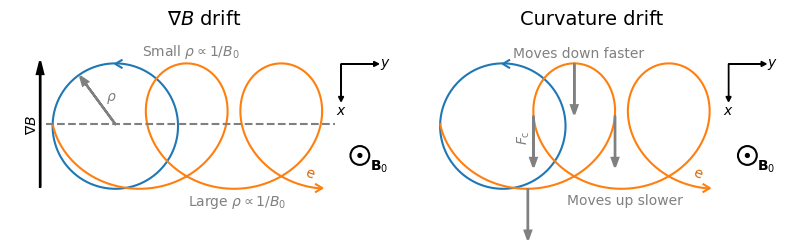

In [29]:
omega_c = 1
v_perp = 0.5
r_L = v_perp/omega_c
fontsize_superscript = 10

def single_particle_trajectory(nT=10,v_d=np.array([0, 0, 0])):
    # Set time resolution & velocity such that proton goes 1 meter along B per rotation
    T = 2 * np.pi / omega_c  # rotation period
    v_parallel = 1 / T
    dt = T / 1e2

    # Evolve motion
    timesteps = np.arange(0, nT * T, dt)

    x = np.zeros(len(timesteps))
    y = np.zeros(len(timesteps))
    x[0] = 0.1
    y[0] = 0.5

    for i, t in enumerate(timesteps[:-1]): 
        v_x = v_perp * np.cos(omega_c * t-np.pi/2) + v_d[0]
        v_y = v_perp * np.sin(omega_c * t-np.pi/2) + v_d[1]
        x[i+1] = x[i] + v_x * dt
        y[i+1] = y[i] + v_y * dt
    z = v_parallel * timesteps

    return x, y, z


fig, ax = plt.subplots(1,2, figsize=(10,4),gridspec_kw={'wspace':0.})

x, y, z = single_particle_trajectory(1.01)
xd, yd, zd = single_particle_trajectory(2.25,[0.12,0,0])

ax[0].plot(x,y,c='C0')
ax[0].plot([0.65,0.6,0.65],[0.95,0.98,1.01],c='C0')
ax[0].plot(xd,yd,c='C1')
ax[0].plot([2.2,2.25,2.2],[-0.04,-0.01,0.02],c='C1')

# x/y axes
ax[0].arrow(2.4,0.98,0.3,0,color='black',head_width=0.04,head_length=0.04,lw=1,length_includes_head=True)
ax[0].arrow(2.4,0.98,0,-0.3,color='black',head_width=0.04,head_length=0.04,lw=1,length_includes_head=True)
ax[0].annotate(r"$y$",(2.71,0.98),va='center',ha='left',fontsize=fontsize_superscript,c='black',zorder=10)
ax[0].annotate(r"$x$",(2.4,0.67),va='top',ha='center',fontsize=fontsize_superscript,c='black',zorder=10)

# B
ax[0].add_patch(Ellipse((2.55,0.25),0.15,0.15,color='black',fill=False,lw=1.5))
ax[0].add_patch(Ellipse((2.55,0.25),0.03,0.03,color='black'))
ax[0].annotate(r"$\mathbf{B}_0$",(2.63,0.23),va='top',ha='left',c='black',fontsize=10)

# grad B
ax[0].arrow(0,0,0,1,color='black',overhang=0,head_width=0.05,head_length=0.1,length_includes_head=True,lw=1.7)
ax[0].annotate(r'$\nabla B$',(-0.01,0.5),va='center',ha='right',c='black',fontsize=10,rotation=90)

# High/low B
ax[0].plot([0.05,2.35],[0.5,0.5],ls='--',c='grey')
ax[0].annotate(r'Small $\rho\propto 1/B_0$',(1.2,1.01),va='bottom',ha='center',c='grey',fontsize=10)
ax[0].annotate(r'Large $\rho\propto 1/B_0$',(1.57,-0.05),va='top',ha='center',c='grey',fontsize=10)

# Electron
ax[0].annotate(r'e',(2.15,0.05),va='bottom',ha='center',c='#d46808',fontsize=10,rotation=-20)

ax[0].set_aspect(1)
ax[0].set_xticks([],[])
ax[0].set_yticks([],[])
ax[0].set_xlim(-0.24,2.85)
ax[0].set_ylim(-0.44,1.23)
ax[0].axis('off')
ax[0].set_title(r"$\nabla B$ drift",y=1,fontsize=14)




x, y, z = single_particle_trajectory(1.01)
xd, yd, zd = single_particle_trajectory(2.25,[0.12,0,0])

ax[1].plot(x,y,c='C0')
ax[1].plot([0.65,0.6,0.65],[0.95,0.98,1.01],c='C0')
ax[1].plot(xd,yd,c='C1')
ax[1].plot([2.2,2.25,2.2],[-0.04,-0.01,0.02],c='C1')

# x/y axes
ax[1].arrow(2.4,0.98,0.3,0,color='black',head_width=0.04,head_length=0.04,lw=1,length_includes_head=True)
ax[1].arrow(2.4,0.98,0,-0.3,color='black',head_width=0.04,head_length=0.04,lw=1,length_includes_head=True)
ax[1].annotate(r"$y$",(2.71,0.98),va='center',ha='left',fontsize=fontsize_superscript,c='black',zorder=10)
ax[1].annotate(r"$x$",(2.4,0.67),va='top',ha='center',fontsize=fontsize_superscript,c='black',zorder=10)

# B
ax[1].add_patch(Ellipse((2.55,0.25),0.15,0.15,color='black',fill=False,lw=1.5))
ax[1].add_patch(Ellipse((2.55,0.25),0.03,0.03,color='black'))
ax[1].annotate(r"$\mathbf{B}_0$",(2.63,0.23),va='top',ha='left',c='black',fontsize=10)

# Centrifugal force
ax[1].arrow(0.844,0.56,0,-0.4,color='grey',head_width=0.05,head_length=0.07,lw=1.7,length_includes_head=True,zorder=10)
ax[1].annotate(r'$F_\text{c}$',(0.83,0.4),va='center',ha='right',c='grey',fontsize=10,rotation=90)
ax[1].arrow(1.4945,0.56,0,-0.4,color='grey',head_width=0.05,head_length=0.07,lw=1.7,length_includes_head=True,zorder=10)
ax[1].arrow(1.1695,0.98,0,-0.4,color='grey',head_width=0.05,head_length=0.07,lw=1.7,length_includes_head=True,zorder=10)
ax[1].arrow(0.8,-0.02,0,-0.4,color='grey',head_width=0.05,head_length=0.07,lw=1.7,length_includes_head=True,zorder=10)
ax[1].annotate(r'Moves down faster',(1.2,1.01),va='bottom',ha='center',c='grey',fontsize=10)
ax[1].annotate(r'Moves up slower',(1.57,-0.05),va='top',ha='center',c='grey',fontsize=10)

# Electron
ax[1].annotate(r'e',(2.15,0.05),va='bottom',ha='center',c='#d46808',fontsize=10,rotation=-20)

ax[1].set_aspect(1)
ax[1].set_xticks([],[])
ax[1].set_yticks([],[])
ax[1].set_xlim(-0.24,2.85)
ax[1].set_ylim(-0.44,1.23)
ax[1].axis('off')
ax[1].set_title(r"Curvature drift",y=1,fontsize=14)

ax[0].arrow(0.6,0.5,-0.28,0.38,color='grey',head_width=0.05,head_length=0.07,lw=1.7,length_includes_head=True,zorder=10)
ax[0].annotate(r'$\rho$',(0.57,0.65),va='bottom',ha='center',c='grey',fontsize=10,rotation=0)

# plt.savefig("drifts_cartoon.pdf",bbox_inches='tight')

plt.show()

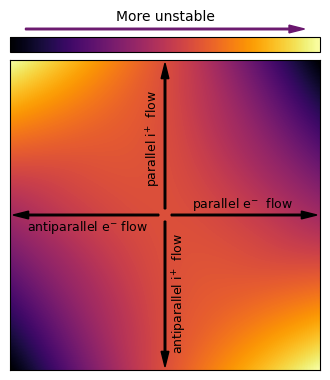

In [ ]:
# Get velocities and eigenvalues from data dictionary
V, O = eigenvalues['RFP_nTEM_ky01275']
# Get parameters for this simulation
par = parameters_RFP_nTEM
# Set levels and ticks for gamma and omega
lg = np.linspace(0.118,0.187,15)
tg = np.arange(0.120,0.181,0.010)
lo = np.linspace(-0.138,-0.095,15)
to = np.arange(-0.135,-0.095,0.008)

# Interpolate data for clean plot
N = 500
Vi, Ve = np.mgrid[V[:,0].min():V[:,0].max():N*1j,V[:,1].min():V[:,1].max():N*1j]
gamma = griddata(V, O[:,0], (Vi, Ve), method='cubic')
omega = griddata(V, O[:,1], (Vi, Ve), method='cubic')

# Create figure
fig, ax = plt.subplots(1,1,figsize=(4,5))

# cf = ax.contourf(Ve,Vi,gamma,cmap='inferno',levels=300)
cf = ax.imshow(gamma,cmap='inferno',origin='lower',extent=[-0.1,0.1,-0.1,0.1])
cbar = fig.colorbar(cf,pad=0.02,orientation='horizontal',location='top')
ax.arrow(-0.09,0.12,0.18,0,head_length=0.01,head_width=0.005,color=plt.get_cmap('inferno')(0.3),length_includes_head=True,clip_on=False)
cbar.set_label('More unstable',labelpad=12)
cbar.ax.set_xticks([]) 

ax.set_xlim(Ve.min(),Ve.max())
ax.set_ylim(Vi.min(),Vi.max())
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

ax.arrow(0.004,0,0.094,0,head_length=0.01,head_width=0.005,color='k',length_includes_head=True)
ax.arrow(-0.004,0,-0.094,0,head_length=0.01,head_width=0.005,color='k',length_includes_head=True)
ax.arrow(0,0.004,0,0.094,head_length=0.01,head_width=0.005,color='k',length_includes_head=True)
ax.arrow(0,-0.004,0,-0.094,head_length=0.01,head_width=0.005,color='k',length_includes_head=True)
ax.annotate(r'parallel $\mathrm{e}^{-}$  flow',(0.05,0.002),ha='center',va='bottom',fontsize=9)
ax.annotate(r'antiparallel $\mathrm{e}^{-}$ flow',(-0.05,-0.002),ha='center',va='top',fontsize=9)
ax.annotate(r'parallel $\mathrm{i}^{+}$  flow',(-0.0015,0.05),ha='right',va='center',fontsize=9,rotation=90)
ax.annotate(r'antiparallel $\mathrm{i}^{+}$  flow',(0.0035,-0.05),ha='left',va='center',fontsize=9,rotation=90)

plt.savefig("SCP_growthrate.svg",bbox_inches='tight')
plt.show()

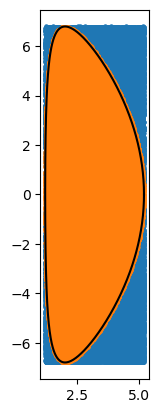

40.68678466731853 54.39991532158322


In [ ]:
## Find plasma cross-section surface area of a hypothetical ITER-scale RFP
R0 = 3.2
a = 2.0
kappa = 3.4
delta = 0.64

theta = np.linspace(0,np.pi*2,1000)
R = R0 + a*np.cos(theta+delta*np.sin(theta))
Z = kappa*a*np.sin(theta)

points = np.random.rand(100000,2)*np.array([R.max()-R.min(),Z.max()-Z.min()])+np.array([R.min(),Z.min()])
from matplotlib.path import Path
inside = contour_path = Path(np.c_[R, Z], closed=True).contains_points(points)

plt.scatter(*points[~inside].T,s=5)
plt.scatter(*points[inside].T,s=5)
plt.plot(R, Z,c='black')
plt.gca().set_aspect('equal')
plt.show()

A_box = (R.max()-R.min())*(Z.max()-Z.min())
A_inside = A_box*sum(inside)/len(inside)
print(A_inside,A_box)

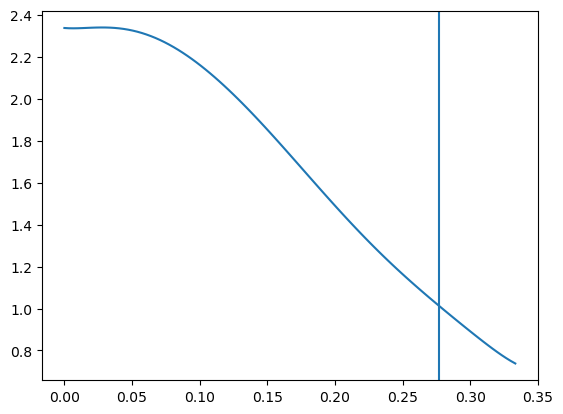

In [14]:
## Madison Symmetric Torus RFP magnetic field profile used in RFP nTEM sims
Bprof_coeffs  = [4.8705656, -1.1183775, 117.00145, -3235.7918, 29839.986, -162001.71, 538939.02, -989839.01, 757653.81 ]

Bx = Polynomial(Bprof_coeffs)
x = np.linspace(0,0.5/1.5,100)
plt.axvline(0.83*0.5/1.5)
plt.plot(x,Bx(x)*0.48)
plt.show()

In [ ]:
from sympy.functions.special.error_functions import erf as erf_s
from sympy import exp as exp_s
from sympy import Abs as abs_s
from sympy import I

def Z(x):
    # return 1j*np.sqrt(np.pi)*exp_s(-x**2)*(1+erf_s(1j*x))
    return 1j*np.sqrt(np.pi)*(1-x**2)-2*x

def dispersion_eq(zi,vpar0i,vpar0e,T0i,T0e,vThi,omn,omTi,B0,J,Kx,Ky,kx,ky,kz,gradvpar0i,gradvpar0e,omc=None):
    if omc is None: omc = symbols('omega_c',complex=True)

    if isinstance(zi,int):
        B0 = B0[zi]; Kx = Kx[zi]; Ky = Ky[zi]; J = J[zi]
    else:
        B0 = B0.mean(); Kx = Kx.mean(); Ky = Ky.mean(); J = J.mean()

    G = J*B0/(kz*vThi)
    omdhati = T0i/B0*(Kx*kx+Ky*ky)
    O = G*omc-vpar0i

    Z3 = -2*(1+O*Z(O))
    Z5 = (1-2*O)*Z(O)-2
    Z6 = 2*O**2*Z(O)+2*O**2*(1-2*Z(O))-2*O*(2-Z(O))+1
    Z7 = 2*O*Z6-O**2*Z5
    Z8 = 0.5+2*O*Z7-O**2*Z6

    eq = -T0i/T0e*(1+vpar0e*Z(-vpar0e))
    eq += T0i*ky*G*(-omn*Z(O) - omTi*((O**2-0.5)*Z(O)+3*O) 
                    + 2*gradvpar0i*(1+O*Z(O)))
    eq += omdhati*G*(-6*O-(2*O+1)*Z(O)-2*vpar0i*(1+O*Z(O)))
    eq += -1-O*Z(O)
    eq += omdhati*T0i*ky*G**2*(omn*(2*Z6+4*vpar0i*Z5+(vpar0i**2+1)*Z3)
        +omTi*(2*Z8+4*vpar0i*Z7+2*vpar0i**2*Z6-2*vpar0i*Z5+(0.5-vpar0i**2)*Z3)
        -2*gradvpar0i*(2*Z7+4*vpar0i*Z6+(2*vpar0i**2+1)*Z5))
    eq += omdhati**2*G**2*(Z8+3*vpar0i*Z7+(4+3*vpar0i**2)*Z6
            +(6*vpar0i+vpar0i**2)*Z5+(2+2*vpar0i**2)*Z3)
    eq += omdhati*(2*Z7+4*vpar0i*Z6+(2*vpar0i**2+1)*Z5)

    return eq

omc, omega, gamma = symbols('omega_c, omega, gamma')
eq = dispersion_eq(8,0,0,P.T0i,P.T0e,P.vThi,P.omn,P.omti,P.B0,P.J,P.Kx,P.Ky,P.kx,P.ky,0.9,0,0,omc)

In [ ]:
from scipy.ndimage import maximum_filter, generate_binary_structure, binary_erosion

def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array
    """
    neighborhood = generate_binary_structure(2,2)
    local_max = maximum_filter(image, footprint=neighborhood)==image
    background = (image==0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

om, gm = np.linspace(-2,2,200), np.linspace(-1,1,100)
OM, GM = np.meshgrid(om,gm)

N = 51
n = 6
Vi, Ve = np.mgrid[-0.1:0.1:N*1j,-0.1:0.1:N*1j]
roots = np.empty([*Vi.shape,n],dtype=complex)
for i in range(N):
    for e in range(N):
        disp = np.abs(dispersion_eq(8,Vi[i,e],Ve[i,e],P.T0i,P.T0e,P.vThi,P.omn,P.omti,P.B0,P.J,P.Kx,P.Ky,P.kx,P.ky,0.9,0,0,OM+1j*GM))
        peaks = detect_peaks(disp.max()-disp)
        pj,pi = np.where(peaks)
        roots[i,e,:len(pi)] = om[pi]+1j*gm[pj]

        # plt.contour(om,gm,disp,levels=150,cmap='Greys_r')
        # plt.contourf(om,gm,disp,cmap='jet',levels=np.linspace(0,4,100))
        # plt.colorbar()
        # plt.scatter(om[pi],gm[pj],edgecolor='m',facecolor='w',linewidth=2)
        # for l,pos in enumerate(zip(om[pi],gm[pj])):
        #     plt.annotate(f'{l+1}',pos)
        # plt.axhline(0,c='k',lw=0.7); plt.axvline(0,c='k',lw=0.7)
        # plt.show()

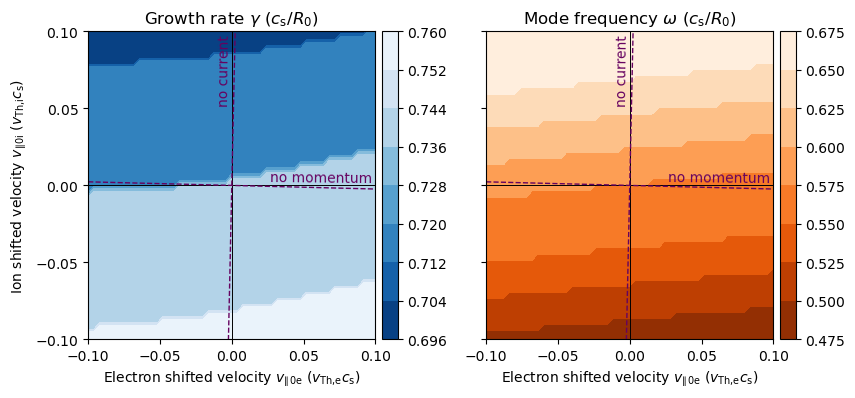

In [ ]:
i = 5
mask = np.abs(roots[:,:,i])<=0.1
if mask.any():
    gamma = roots[:,:,i].imag*(~mask)+roots[:,:,i-1].imag*mask
    omega = roots[:,:,i].real*(~mask)+roots[:,:,i-1].real*mask

# Create figure
fig, ax = plt.subplots(1,2,figsize=(9.6,4),sharey=True,gridspec_kw={'wspace':0.15})

cf = ax[0].contourf(Ve,Vi,gamma,cmap='Blues_r')
ax[0].set_title(r'Growth rate $\gamma$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
# tg = cbar.ax.get_yticks()
# cbar.ax.set_yticks(tg, [f"${t:.3f}$" for t in tg]) 

cf = ax[1].contourf(Ve,Vi,omega,cmap='Oranges_r')
ax[1].set_title(r'Mode frequency $\omega$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
# to = np.arange(0.070,0.150,0.015)
# cbar.ax.set_yticks(to, [f"${t:.3f}$" for t in to]) 

for axi in ax:
    axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
    axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
    axi.set_xlabel(r"Electron shifted velocity $v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{s}$)")
    axi.set_xlim(Ve.min(),Ve.max())

    c_an = '#660260'
    axi.plot([-0.1,0.1],[-0.1*P.vThe/P.vThi,0.1*P.vThe/P.vThi],c=c_an,lw=1,ls='--')
    axi.annotate("no current",[0,0.098],c=c_an,rotation=89.4,va='top',ha='right')
    axi.plot([-0.1,0.1],[0.1*P.vThe/P.vThi*P.me/P.mi,-0.1*P.vThe/P.vThi*P.me/P.mi],c=c_an,lw=1,ls='--')
    axi.annotate("no momentum",[0.098,0],c=c_an,rotation=-0.6,va='bottom',ha='right')

ax[0].set_ylim(Vi.min(),Vi.max())
ticks = np.linspace(-0.1,0.1,5)
ax[0].set_yticks(ticks,[f"${t:.2f}$" for t in ticks])
ax[0].set_ylabel(r"Ion shifted velocity $v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}c_\text{s}$)")
# fig.suptitle(r"RFP $\nabla n$-TEM",y=1)
# plt.savefig('/home/leon-o/Documents/LaTeX/MSc Thesis/Assets/ITG_roots_eigv_disp.pdf',bbox_inches='tight')

plt.show()

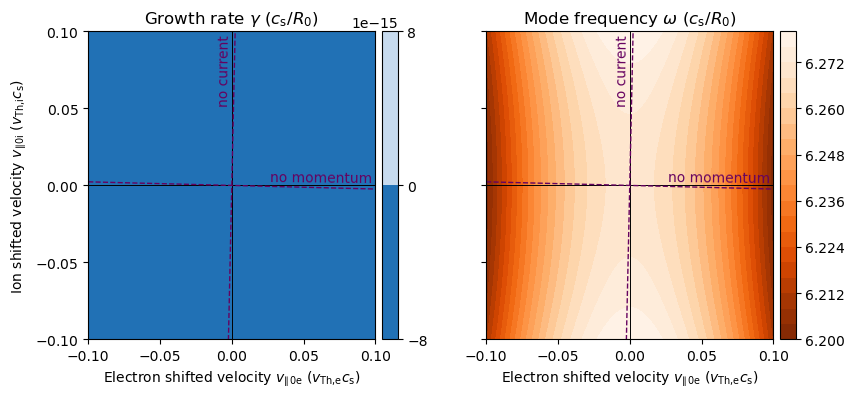

In [ ]:
def dispersion_baby(vpar0i,vpar0e,omn,omti,omte,T0i,T0e,vThi,vThe,J,B0,ky,kpar):
    omstari = omn+omti*(vpar0i**2-3/2)
    omstare = omn+omte*(vpar0e**2-3/2)
    expi = np.exp(-vpar0i**2)/np.pi**(3/2)
    expe = np.exp(-vpar0e**2)/np.pi**(3/2)
    return (omstari*expi-omstare*expe)*ky + kpar/(J*B0)*(vThe/T0e*expe-vThi/T0i*expi)

N = 101
Vi, Ve = np.mgrid[-0.1:0.1:N*1j,-0.1:0.1:N*1j]
        
# Get velocities and eigenvalues from data dictionary
R = dispersion_baby(Vi,Ve,P.omn,P.omti,P.omte,P.T0i,P.T0e,P.vThi,P.vThe,P.J[8],P.B0[8],P.ky,0.9)
gamma, omega = R.imag[:,:], R.real[:,:]

# Create figure
fig, ax = plt.subplots(1,2,figsize=(9.6,4),sharey=True,gridspec_kw={'wspace':0.15})

cf = ax[0].contourf(Ve,Vi,gamma,cmap='Blues_r',levels=25)
ax[0].set_title(r'Growth rate $\gamma$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
# tg = cbar.ax.get_yticks()
# cbar.ax.set_yticks(tg, [f"${t:.3f}$" for t in tg]) 

cf = ax[1].contourf(Ve,Vi,omega,levels=25,cmap='Oranges_r')
ax[1].set_title(r'Mode frequency $\omega$ ($c_\text{s}/R_0$)')
cbar = fig.colorbar(cf,pad=0.02)
# to = np.arange(0.070,0.150,0.015)
# cbar.ax.set_yticks(to, [f"${t:.3f}$" for t in to]) 

for axi in ax:
    axi.plot([0,0],[Vi.min(),Vi.max()],c='black',lw=0.7)
    axi.plot([Ve.min(),Ve.max()],[0,0],c='black',lw=0.7)
    axi.set_xlabel(r"Electron shifted velocity $v_{\!\parallel\!0\text{e}}$ ($v_\text{Th,e}c_\text{s}$)")
    axi.set_xlim(Ve.min(),Ve.max())

    c_an = '#660260'
    axi.plot([-0.1,0.1],[-0.1*P.vThe/P.vThi,0.1*P.vThe/P.vThi],c=c_an,lw=1,ls='--')
    axi.annotate("no current",[0,0.098],c=c_an,rotation=89.4,va='top',ha='right')
    axi.plot([-0.1,0.1],[0.1*P.vThe/P.vThi*P.me/P.mi,-0.1*P.vThe/P.vThi*P.me/P.mi],c=c_an,lw=1,ls='--')
    axi.annotate("no momentum",[0.098,0],c=c_an,rotation=-0.6,va='bottom',ha='right')

ax[0].set_ylim(Vi.min(),Vi.max())
ticks = np.linspace(-0.1,0.1,5)
ax[0].set_yticks(ticks,[f"${t:.2f}$" for t in ticks])
ax[0].set_ylabel(r"Ion shifted velocity $v_{\!\parallel\!0\text{i}}$ ($v_\text{Th,i}c_\text{s}$)")
# fig.suptitle(r"RFP $\nabla n$-TEM",y=1)
# plt.savefig('/home/leon-o/Documents/LaTeX/MSc Thesis/Assets/eigenvalues_tokamak_ITG_disp.pdf',bbox_inches='tight')

plt.show()